for tracking the MOT position as imaged through the JenOptik onto the Thorlabs camera and the scattering from MOT beams 5 and 6 as viewed with the Luca. some of the analysis also incorporates data from the GOODlogger

In [486]:
import numpy as np
from numpy import unravel_index
from matplotlib import pyplot as plt
from matplotlib import image
import matplotlib as mpl
import h5py
import os
from os import walk
import csv
import json
import tifffile  # to load tiff files efficiently
import cv2 # Open-CV for selecting a ROI
import itertools #to flatten a list of list
from scipy.optimize import curve_fit
from scipy import misc
import scipy.ndimage as ndi # for getting center of mass of an image and gaussian filtering
import datetime
import datetime as dt
from datetime import time
from PIL import Image

# for using datetime on x axis
import matplotlib.dates as mdates
import matplotlib.units as munits
munits.registry[dt.datetime] = mdates.ConciseDateConverter()

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"

# for reading the database parameters from goodlogger's my_config.cfg
goodlogger_dir = "C:\\Users\\QC\OneDrive - UW-Madison\\Documents\\LabSoftware\\GOOD_logger"

import psycopg2 as pg
from configparser import ConfigParser
cp = ConfigParser()
cp.read(os.path.join(goodlogger_dir,"my_config.cfg"))
conn_params = {'database':cp['DATABASE_SETUP']['Database'],
                'host':cp['DATABASE_SETUP']['Host'],
                'user':cp['DATABASE_SETUP']['User'],
                'password':cp['DATABASE_SETUP']['Password'],
                'port':cp['DATABASE_SETUP']['Port']}

def get_data_in_time_interval(table, column_names, t_start, t_end, every_n_rows=None, fudge=102):
    database = pg.connect(**conn_params)
    cur = database.cursor()

    t1 = t_start.timestamp()
    t2 = t_end.timestamp() 
    column_names = ['time'] + column_names

    if every_n_rows == None:
        cur.execute(f"SELECT {', '.join(column_names)} FROM {table} where time between {t1} and {t2}")
    else:
        cur.execute(f"""SELECT {', '.join(column_names)} FROM {table} WHERE ROUND({fudge}*time,0)%{fudge*every_n_rows}=0 AND
        time BETWEEN {t1} and {t2}""")
    row = cur.fetchone()
    rows = []
    while row is not None:
        rows.append([float(x) for x in row])
        row = cur.fetchone()
    return np.array(rows)

def get_data_most_recent(table, column_names, nrows):
    database = pg.connect(**conn_params)
    cur = database.cursor()

    column_names = ['time'] + column_names

    cur.execute(f"SELECT {', '.join(column_names)} FROM {table} ORDER BY time DESC LIMIT {nrows}")
    row = cur.fetchone()
    rows = []
    while row is not None:
        rows.append([float(x) for x in row])
        row = cur.fetchone()
    return np.array(rows)

# from https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## 2023.12.15
a more complete study of the change in atom loading. includes logged temperature data, and data from the GOODLogger including Zotino, coil monitors, and magnetometer.

In [450]:
datestr = "2023-12-14\\17\\"
exp_id = '000008596'
imdir = exp_id + '_images'

f = h5py.File(os.path.join(results, datestr, f'{exp_id}-MonitorMOTandExternalBeamPositions.h5'))
counts = np.array(f['datasets']['photocounts'])[1:]
fort_volts = np.array(f['datasets']['FORT_monitor'])[1:]

In [451]:
filenames = [
    "MOTExternalBeamPositions.tif",
    "MOTExternalBeamPositions_X2.tif",
    "MOTExternalBeamPositions_X3.tif",
    "MOTExternalBeamPositions_X4.tif",
    "MOTExternalBeamPositions_X5.tif",
    "MOTExternalBeamPositions_X6.tif",
    "MOTExternalBeamPositions_X7.tif",
    "MOTExternalBeamPositions_X8.tif"
]

tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(os.path.join(results,datestr,imdir,f))
    for f in filenames
]))) # flattening tifstackList

In [452]:
# there should have been twice as many Luca images as ThorCam images, one for each Z beam
# so there is a bug here. it's possible the Luca needs more time between successive images
len(tifstack), len(thor_filenames)

(7580, 3790)

### ThorCam image processing

In [538]:
# find the MOT position and half-width along x and y

audit = False # plot a random 5 images and the corresponding fits
thor_filenames = [f for f in next(walk(os.path.join(results,datestr,imdir)), 
                             (None, None, []))[2] if f[-3:]=='bmp']  # [] if no file

n_files = len(thor_filenames)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

xmeans = np.empty(n_files)
ymeans = np.empty(n_files)
xwidths = np.empty(n_files)
ywidths = np.empty(n_files)

# get the dimensions
f = os.path.join(results,datestr,imdir,thor_filenames[0])
im = np.array(Image.open(f).convert('L'))
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)

# background - X coil is offset so there isn't a MOT
mot_bg = np.array(Image.open(os.path.join(results,datestr,imdir,'background.bmp')).convert('L'))

for i in iterations:
    f = os.path.join(results,datestr,imdir,thor_filenames[i])
    raw_im = np.array(Image.open(f).convert('L'))
    # im = np.array(Image.open(f).convert('L'))
    
    # gaussian filter the image - the background
    # im = ndi.gaussian_filter(mot_bg-image,5)
    
    # gaussian filter the background then subtract then filter again
    im = ndi.gaussian_filter(ndi.gaussian_filter(mot_bg,10)-raw_im,5)
    
    motx = np.sum(im, axis=0).astype(float)
    motx -= np.amin(motx)
    motx /= np.amax(motx)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,700,50,0.1)
    upper_bounds = [1.2,1000,300,5]
    lower_bounds = [0,300,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    xmeans[i] = x0
    xwidths[i] = wx

    moty = np.sum(im, axis=1).astype(float)
    moty -= np.amin(moty)
    moty /= np.amax(moty)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,600,400,0.1)
    upper_bounds = [1.2,1400,1000,0.5]
    lower_bounds = [0,300,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    ymeans[i] = y0
    ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        ax=plt.imshow(im)
        plt.colorbar(ax)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(motx)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(moty)
        plt.plot(model(ypts, *popty))
        plt.show()

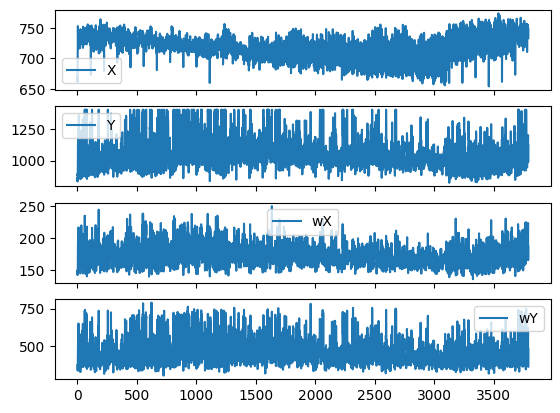

In [284]:
fig,axes = plt.subplots(nrows=4,sharex=True)
ax,ax2,ax3,ax4 = axes
ax.plot(xmeans,label='X')
ax2.plot(ymeans,label='Y')
ax3.plot(xwidths,label='wX')
ax4.plot(ywidths,label='wY')
for ax in axes:
    ax.legend()
# ax3.set_ylim((0,1))

Text(0.5, 0, 'time (10 s)')

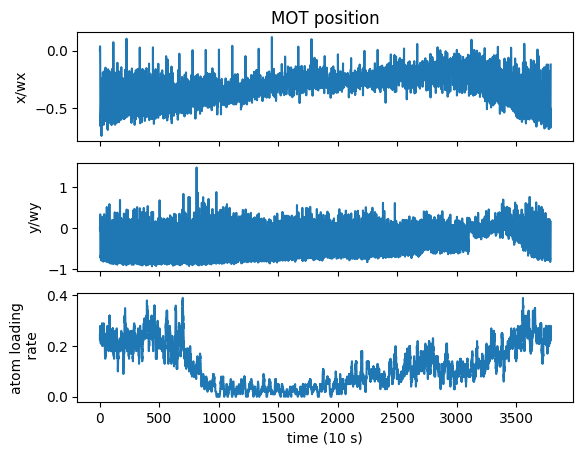

In [540]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=3,sharex=True)
ax,ax2,ax3 = axes
ax.plot((xmeans- xmeans[0])/wx )
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy)
ax2.set_ylabel("y/wy")
ax.set_title("MOT position")
atom = [1 if x > 180 else 0 for x in counts]
loading_rate = np.convolve(atom,np.ones(100)/100,'valid')
ax3.plot(np.linspace(0,len(xwidths),len(loading_rate)),loading_rate)
ax3.set_ylabel("atom loading\n rate")
ax3.set_xlabel("time (10 s)")

#### single image test cell

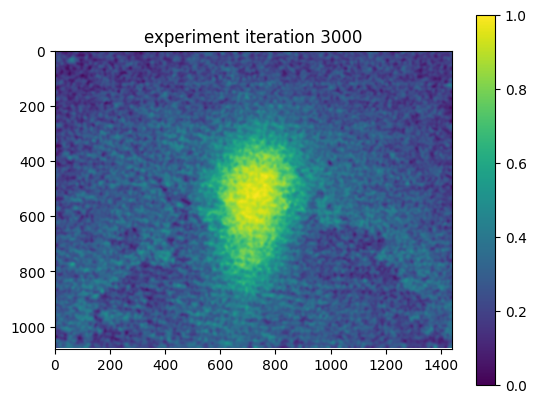

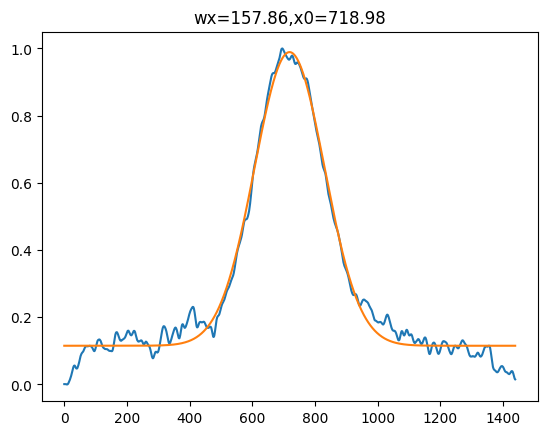

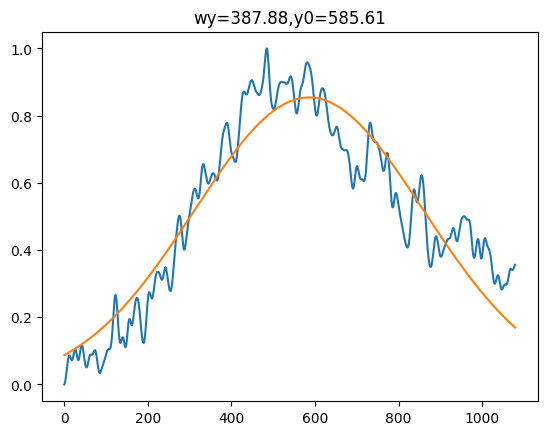

In [572]:
i = 3000
f = os.path.join(results,datestr,imdir,thor_filenames[i])
image = np.array(Image.open(os.path.join(results,datestr,imdir,f)).convert('L'))
mot_bg = np.array(Image.open(os.path.join(results,datestr,imdir,'background.bmp')).convert('L'))

# gaussian filter the image - the background
# im = ndi.gaussian_filter(mot_bg-image,5)

# gaussian filter the background then subtract then filter again
im = ndi.gaussian_filter(ndi.gaussian_filter(mot_bg,10)-image,5)

motx = np.sum(im, axis=0).astype(float)
motx -= np.amin(motx)
motx /= np.amax(motx)

# amplitude, mean x, 1/e width, offset (background)
initial_guess = (1,700,50,0.1)
upper_bounds = [1.2,1000,300,5]
lower_bounds = [0,300,5,0]

# xfit
poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
a, x0, wx, b = poptx
xmeans[i] = x0
xwidths[i] = wx

moty = np.sum(im, axis=1).astype(float)
moty -= np.amin(moty)
moty /= np.amax(moty)

# amplitude, mean y, 1/e width, offset (background)
initial_guess = (1,600,400,0.1)
upper_bounds = [1.2,1400,1000,0.5]
lower_bounds = [0,300,5,0]

# yfit
popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
a, y0, wy, b = popty
ymeans[i] = y0
ywidths[i] = wy

plt.title(f"experiment iteration {i}")
im_normed = (im-np.min(im)).astype(float)
im_normed /= np.amax(im_normed)
ax=plt.imshow(im_normed)
# mpl.colors.Normalize(vmin=0, vmax=1)
plt.colorbar(ax)#,vmin=np.amin(im),vmax=np.amax(im))
plt.show()
plt.title(f"wx={wx:.2f},x0={x0:.2f}")
plt.plot(motx)
plt.plot(model(xpts, *poptx))
plt.show()
plt.title(f"wy={wy:.2f},y0={y0:.2f}")
plt.plot(moty)
plt.plot(model(ypts, *popty))
plt.show()

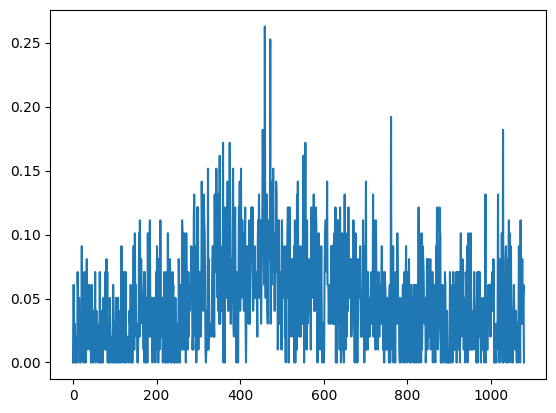

In [482]:
# plt.plot(im_normed[im_normed.shape[0]//2,:])
plt.plot(im_normed[:,im_normed.shape[1]//2])

### Luca image processing

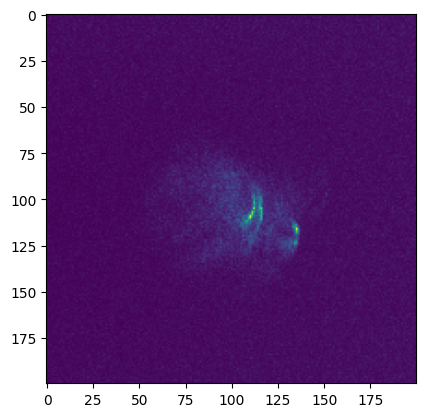

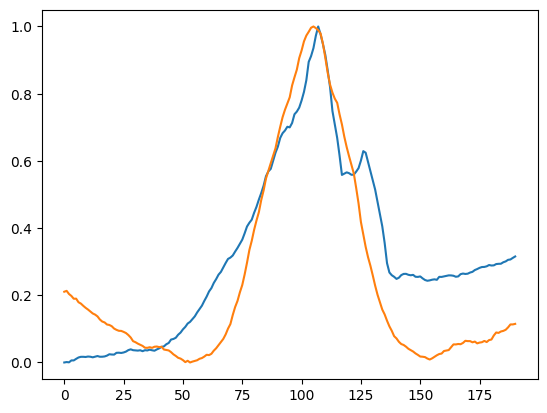

In [226]:
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[100][ymin:ymax,xmin:xmax]
bg = np.mean(im[:20,:20])
sub_im = np.copy(im)
# sub_im[sub_im < np.mean(sub_im)] = 0
plt.imshow(sub_im)
plt.show()
# plt.colorbar()
# cy,cx = ndi.center_of_mass(sub_im)
# print(cy,cx)
# plt.imshow(im)
# plt.scatter([cx],[cy])

mot5x = np.convolve(np.sum(sub_im,axis=0),np.ones(10)/10,'valid')
mot5x -= np.amin(mot5x)
mot5x /= np.amax(mot5x)
mot5y = np.convolve(np.sum(sub_im,axis=1),np.ones(10)/10,'valid')
mot5y -= np.amin(mot5y)
mot5y /= np.amax(mot5y)

plt.plot(mot5x)
plt.plot(mot5y)

In [320]:
audit = False # plot a few random images and the corresponding fits

n_files = len(tifstack)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

mot5xmeans = np.empty(n_files//2)
mot5ymeans = np.empty(n_files//2)
mot5xwidths = np.empty(n_files//2)
mot5ywidths = np.empty(n_files//2)
mot6xmeans = np.empty(n_files//2)
mot6ymeans = np.empty(n_files//2)
mot6xwidths = np.empty(n_files//2)
mot6ywidths = np.empty(n_files//2)

# get the dimensions for our chosen roi
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[0][ymin:ymax,xmin:xmax]
rows, cols = im.shape
xpts = range(cols-(10-1))
ypts = range(rows-(10-1))

for i in iterations:
    im = tifstack[i][ymin:ymax,xmin:xmax]

    if i%2:
        j = (i-1)//2
        
        # mot5x = np.sum(im, axis=0).astype(float)
        mot5x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot5x -= np.amin(mot5x)
        mot5x /= np.amax(mot5x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx5, pcov = curve_fit(model, xpts, mot5x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx5
        mot5xmeans[j] = x0
        mot5xwidths[j] = wx
    
        # mot5y = np.sum(im, axis=1).astype(float)
        mot5y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot5y -= np.amin(mot5y)
        mot5y /= np.amax(mot5y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty5, pcov = curve_fit(model, ypts, mot5y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty5
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot5x)
            plt.plot(model(xpts, *poptx5))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot5y)
            plt.plot(model(ypts, *popty5))
            plt.show()
    
    else:
        j = i//2
        
        # mot6x = np.sum(im, axis=0).astype(float)
        mot6x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot6x -= np.amin(mot6x)
        mot6x /= np.amax(mot6x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx6, pcov = curve_fit(model, xpts, mot6x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx6
        mot6xmeans[j] = x0
        mot6xwidths[j] = wx
    
        # mot6y = np.sum(im, axis=1).astype(float)
        mot6y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot6y -= np.amin(mot6y)
        mot6y /= np.amax(mot6y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty6, pcov = curve_fit(model, ypts, mot6y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty6
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot6x)
            plt.plot(model(xpts, *poptx6))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot6y)
            plt.plot(model(ypts, *popty6))
            plt.show()

### combined data plotting

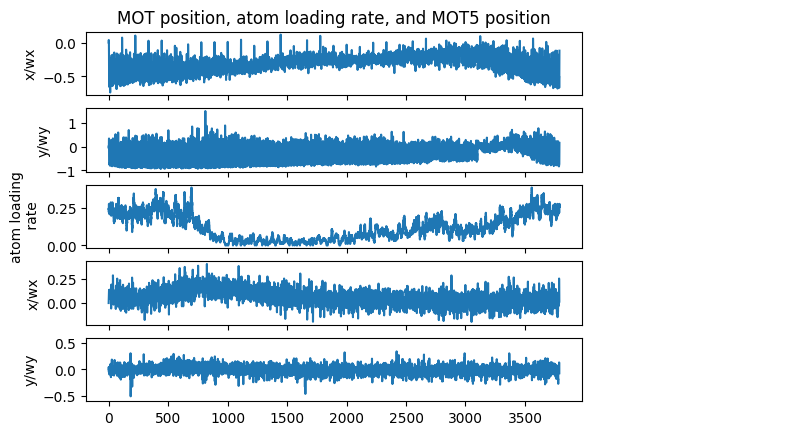

In [542]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot((xmeans- xmeans[0])/wx,label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy,label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
# ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
loading_rate = np.convolve(atom,np.ones(100)/100,'valid')
ax3.plot(np.linspace(0,len(xwidths),len(loading_rate)),loading_rate)
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot((mot5xmeans - mot5xmeans[0]),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
# ax4.set_ylim((-0.05,0.05))
ax5.plot((mot5ymeans - mot5ymeans[0]),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.6,0.6))
# ax5.set_xlabel("time (s)")
fig.legend(loc=(1.01,0.5))

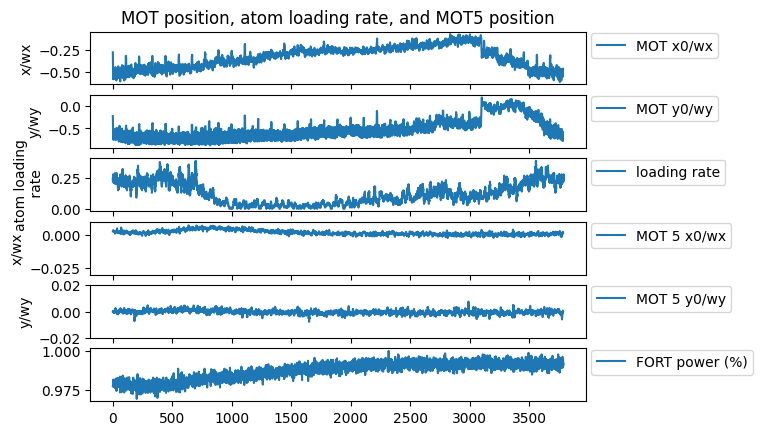

In [731]:
kernel = np.ones(5)/5
roll_avg = lambda data: np.convolve(data, kernel, 'valid')

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)
motxdata = roll_avg((mot5xmeans - mot5xmeans[0])/mot5wx)
# time_s = np.linspace(0,len(),len(motxdata))

# the beam widths
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=6,sharex=True)
ax,ax2,ax3,ax4,ax5,ax6 = axes
ax.plot(roll_avg((xmeans- xmeans[0])/wx)[1:],label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot(roll_avg((ymeans- ymeans[0])/wy)[1:],label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
# atom_counts = np.convolve(atom,np.ones(100)/100,'valid')
loading_rate = np.convolve(atom,np.ones(100)/100,'valid')
loading_rate = np.convolve(atom,np.ones(100)/100,'valid')
ax3.plot(np.linspace(0,len(xmeans),len(loading_rate)),loading_rate,label='loading rate')
ax3.set_ylabel("atom loading\n rate")

ax4.plot(motxdata,label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
ax4.set_ylim((-0.03,0.01))
ax5.plot(roll_avg((mot5ymeans - mot5ymeans[0])/mot5wy),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.02,0.02))
ax5.set_xlabel("time (10 s)")
ax6.plot(fort_volts[2:]/max(fort_volts[2:]),label='FORT power (%)')
for ax in axes:
    ax.legend(loc=(1.01,0.5))

In [666]:
"""The plots below are misleading, because of the way I'm trying to not retrieve every row of data.
the main result is that it looks like the coil timing is way off, but this is not real."""

# get data from Stefan-Mayer 3-axis magnetometer, Zotino, and selected coil monitors
lj_data =  get_data_in_time_interval(table='qn_labjack_channels',
                                column_names=[f'ch{i}' for i in range(1,11)],
                                t_start=dt.datetime(2023, 12, 14, 17, 59),
                                t_end=dt.datetime(2023, 12, 15, 6, 48),
                                every_n_rows=10,
                                fudge=100
)

lj_time, magX, magY, magZ, zotAZtop, zotAX, zotAY, monitorAZbottom, monitorAZtop, monitorAX, monitorAY = lj_data.transpose() # time is unix time in seconds
datetimes = [dt.datetime.fromtimestamp(t) for t in lj_time] # time to datetime

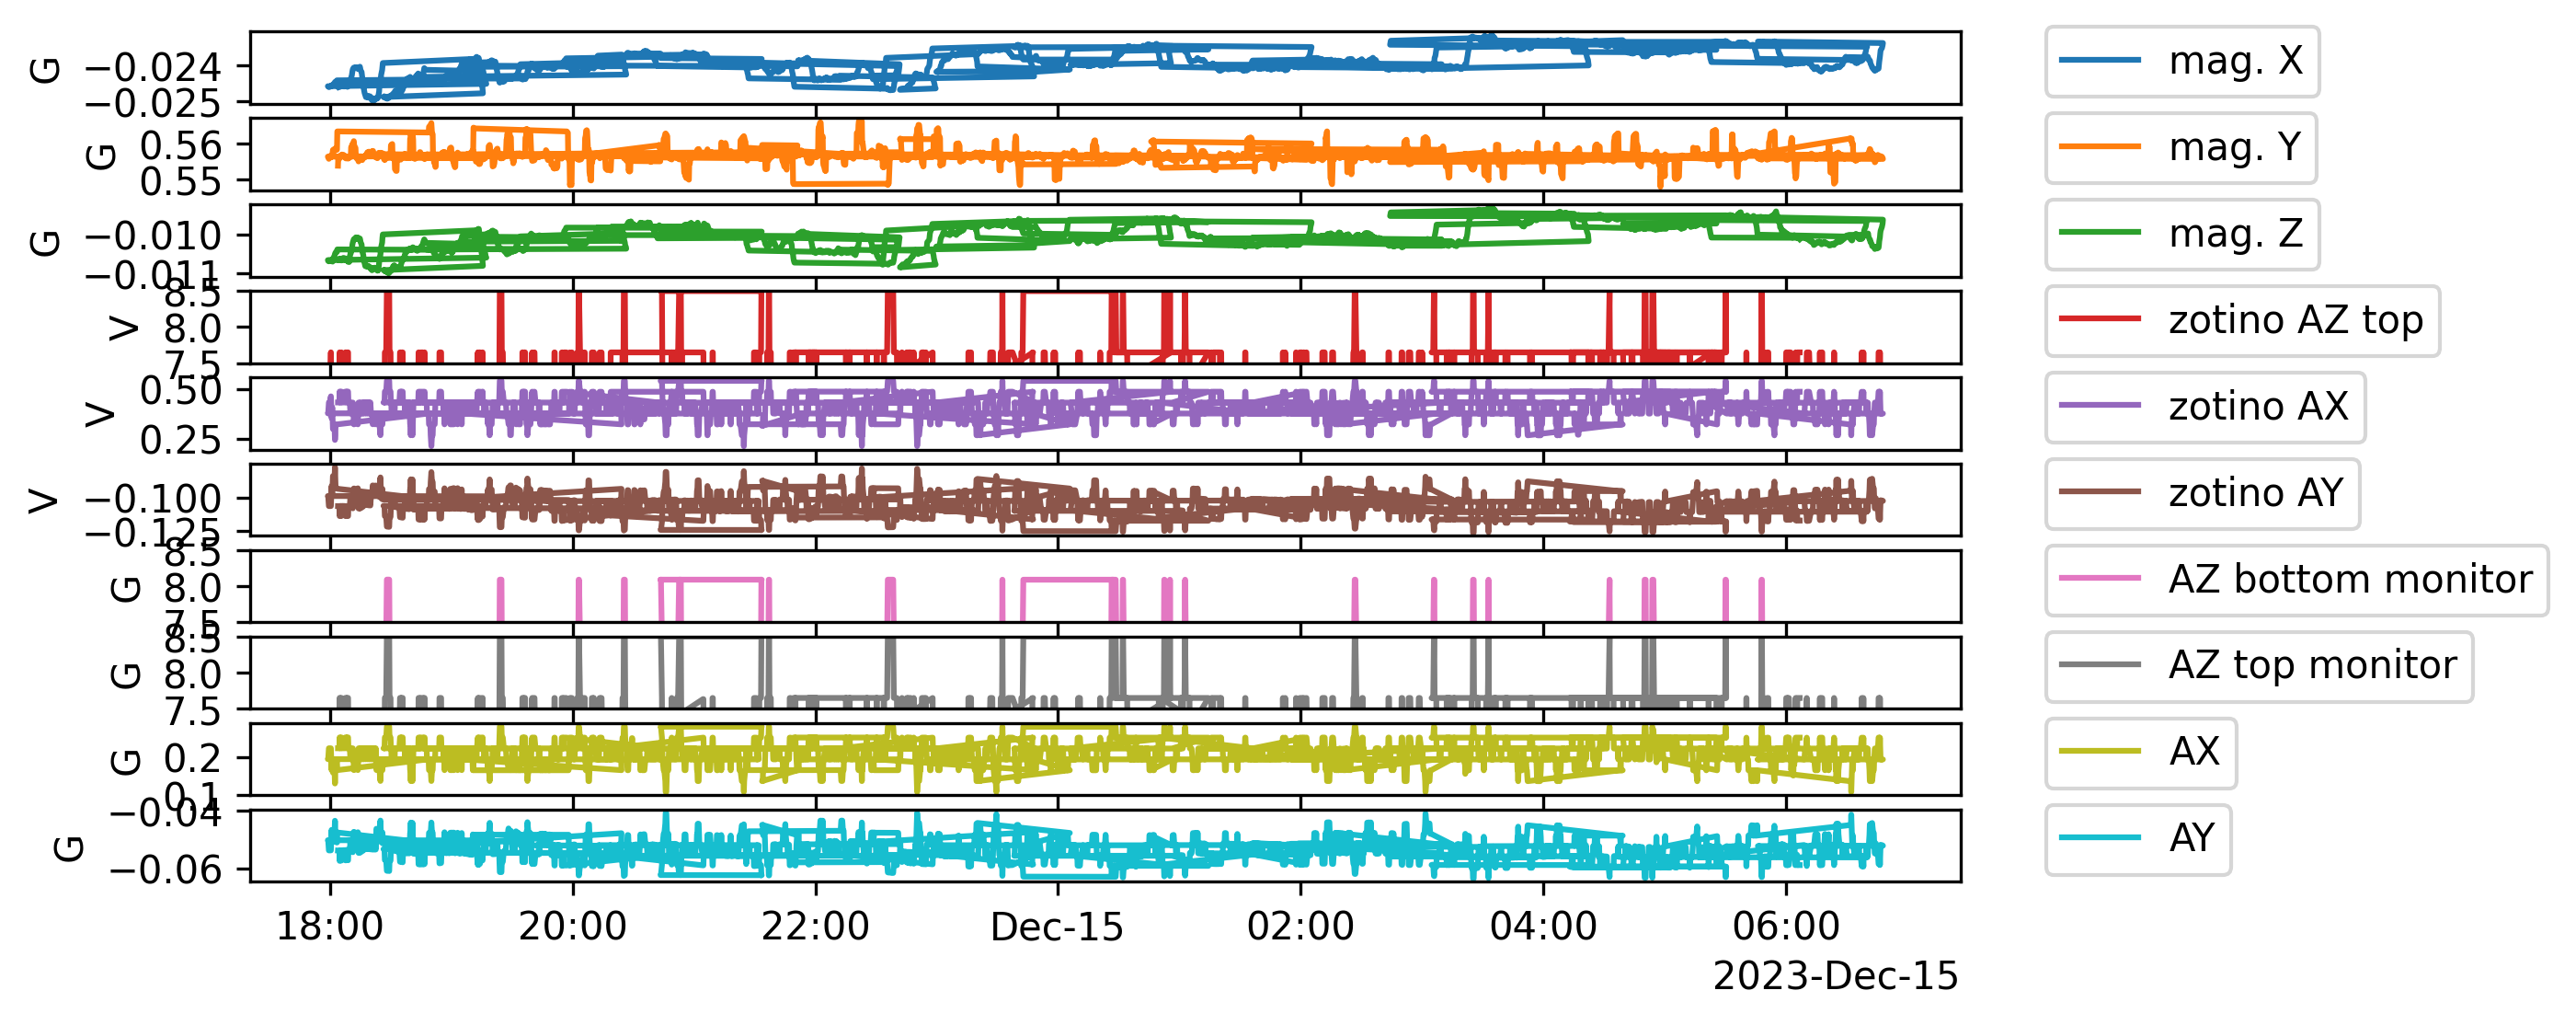

In [667]:
# plot with units G for magnetometer and coil monitor

roll_avg = lambda data, n: np.convolve(data,np.ones(n)/n,'valid')

labels = ['mag. X','mag. Y','mag. Z','zotino AZ top','zotino AX','zotino AY','AZ bottom monitor','AZ top monitor','AX','AY']
ylabels = ['G','G','G','V','V','V','G','G','G','G']

G_per_V_SM = 1e4*35e-6 # G per T * T per V for Stefan-Mayer FLC3-70
G_per_V_AZ_bottom = 8.75/2 # G per A * A per monitor = V for the AZ top shim coil
G_per_V_AZ_top = 8.75/2 # G per A * A per monitor = V for the AZ top shim coil
G_per_V_AX = 2.27 # G per A * A per monitor = V for the AX shim coil
G_per_V_AY = 2.10 # G per A * A per monitor = V for the AY shim coil

lj_channels = [magX*G_per_V_SM, magY*G_per_V_SM, magZ*G_per_V_SM, 
            zotAZtop, zotAX, zotAY, 
            monitorAZbottom*G_per_V_AZ_bottom, monitorAZtop*G_per_V_AZ_top, monitorAX*G_per_V_AX, monitorAY*G_per_V_AY]

avgs = 10

colors = plt.rcParams["axes.prop_cycle"]()
fig,axes = plt.subplots(nrows=len(lj_channels),sharex=True, constrained_layout=False,dpi=300,figsize=(8,4))
ch_i = 0
for ax,ch,lbl,ylbl in zip(axes,lj_channels,labels,ylabels):
    c = next(colors)["color"]
    ax.plot(datetimes[:-(avgs-1)],roll_avg(ch,avgs),label=lbl,color=c)
    ax.set_ylabel(ylbl)
    ax.legend(loc=(1.05,0.1))
    ch_i += 1

axes[3].set_ylim((7.5,8.5))
axes[6].set_ylim((7.5,8.5))
axes[7].set_ylim((7.5,8.5))
plt.show()
# plt.savefig('magnetometer_zotino_coilmonitor_data_20231012.png',bbox_inches='tight')


Z top coil A/V: 0.22867355568028744


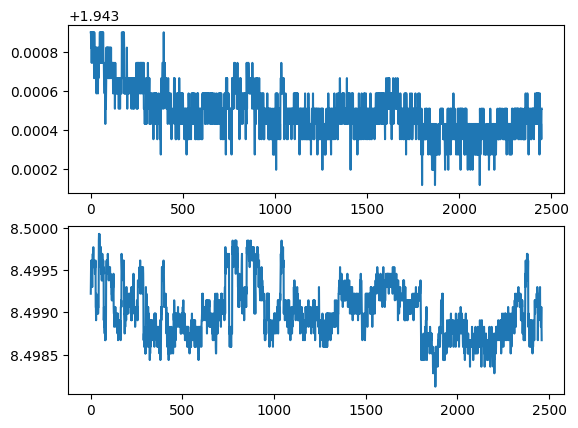

X coil A/V: 0.22694667410421215


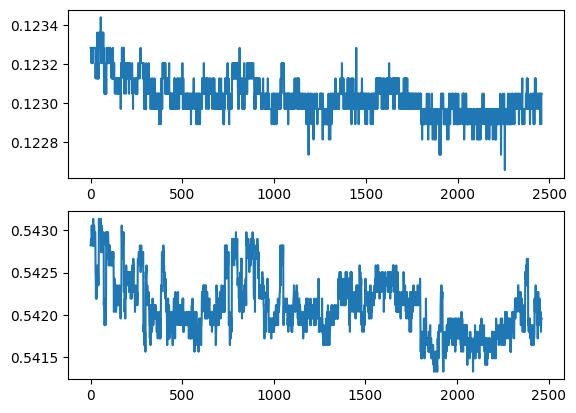

In [789]:
fig,axes = plt.subplots(nrows=2)
axes[0].plot(monitorAZtop[monitorAZtop>1.943])
axes[1].plot(zotAZtop[zotAZtop>8])
print("Z top coil A/V:",np.mean(monitorAZtop[monitorAZtop>1.943])/np.mean(zotAZtop[zotAZtop>8]))
plt.show()

fig,axes = plt.subplots(nrows=2)
axes[0].plot(monitorAX[monitorAX>0.1225])
axes[1].plot(zotAX[zotAX>0.5])
print("X coil A/V:",np.mean(monitorAX[monitorAX>0.1225])/np.mean(zotAX[zotAX>0.5]))
plt.show()

(8.44, 8.5)

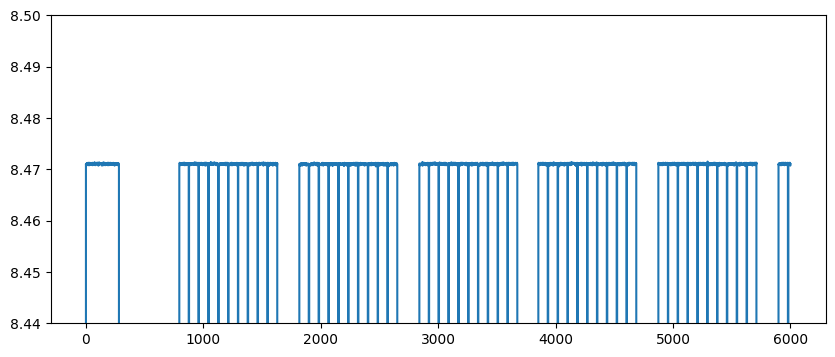

In [373]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(range(100*60),zotAZtop[:100*60])
# ax.plot(range(100*60),zotAZtop[:100*60])
ax.set_ylim((8.44,8.5))

In [653]:
points_per_s = len(lj_time)/(lj_time[-1] - lj_time[0])
points_per_s

0.07285300376593344

In [663]:
len(lj_time), len(lj_channels[0])

(3266, 383449)

In [661]:
ndata

383449

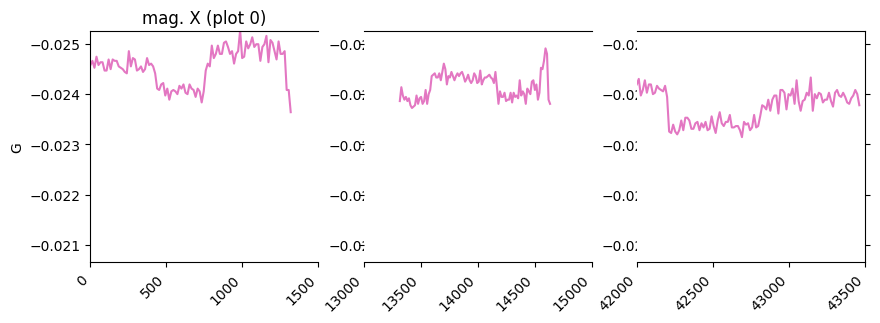

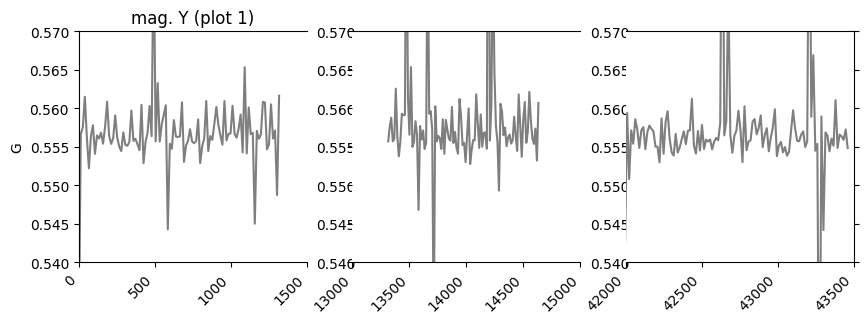

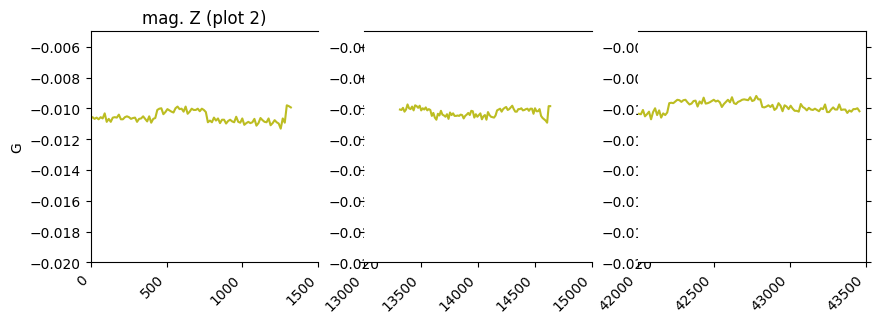

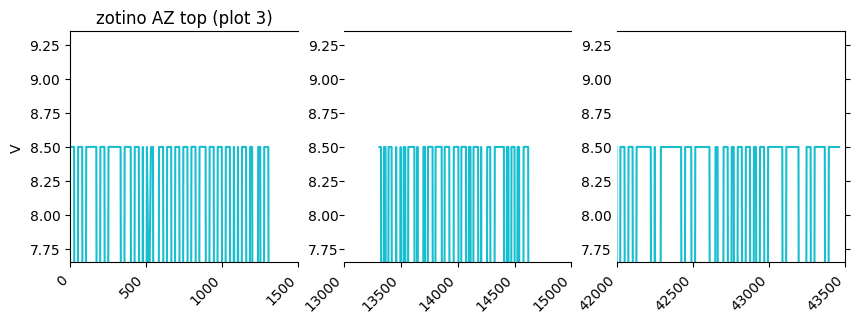

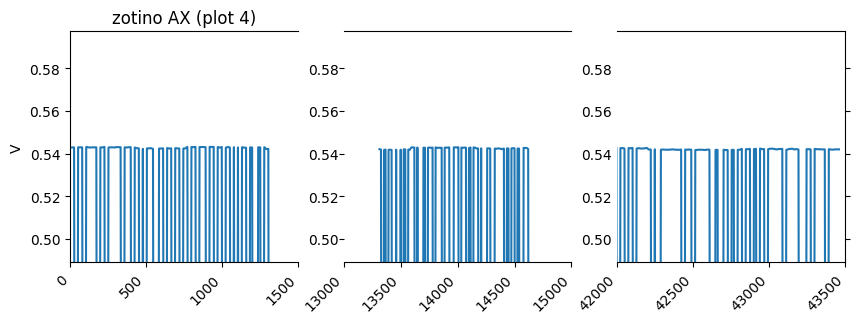

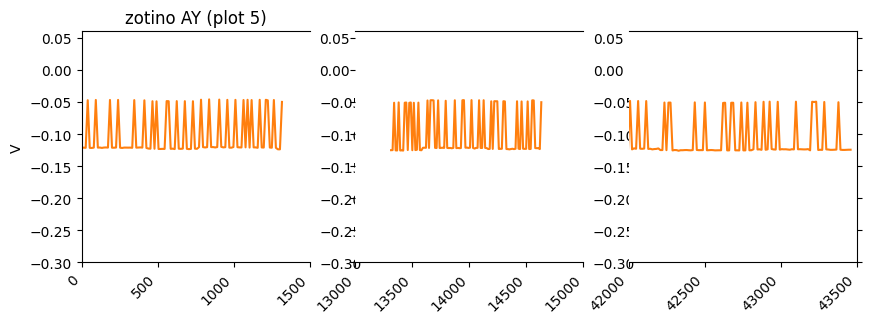

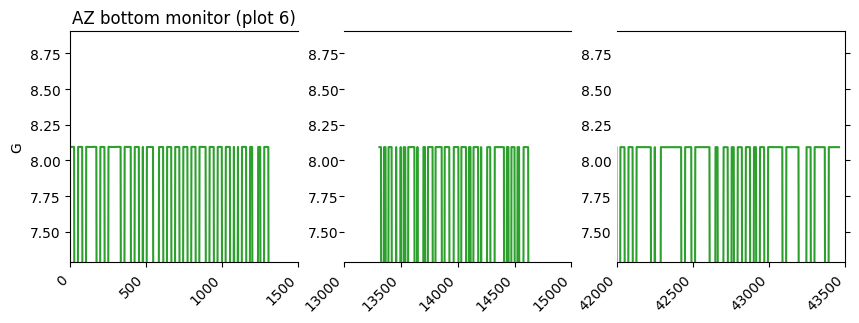

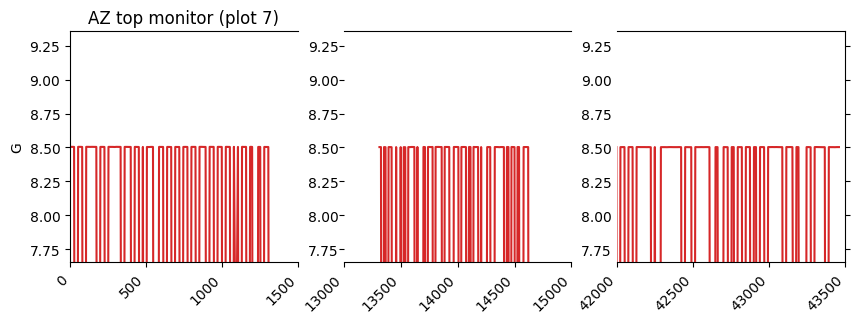

In [769]:
x = np.linspace(0,10,100)

points_per_s = len(lj_time)/(lj_time[-1] - lj_time[0])

seconds = 1 # per section
offset = int(1000*seconds) #4800//2 in seconds

ylims = [None]*len(lj_channels)
ylims[1] = (0.54,0.57)
ylims[2] = (-0.02,-0.005)
# ylims[3] = (8.46, 8.48)
# ylims[4] = (0.5, 0.55)
ylims[5] = (-0.3,0.06)
# ylims[6] = (8.1, 8.5)
# ylims[7] = (8.46, 8.5)
# ylims[-1] = (-0.05,-0.04)

labels = ['mag. X','mag. Y','mag. Z','zotino AZ top','zotino AX','zotino AY','AZ bottom monitor','AZ top monitor','AX','AY']
ch_i = 0
for ax,ch,lbl,ylbl,ylim in zip(axes,lj_channels,labels,ylabels,ylims):
    c = next(colors)["color"]
    # ax.plot(datetimes[:-(avgs-1)],roll_avg(ch,avgs),label=lbl,color=c)
    ax.set_ylabel(ylbl)
    ax.legend(loc=(1.05,0.1))

    data = ch
    ndata = len(ch)
    x = np.linspace(0,ndata,ndata-1)/points_per_s
    y = data
        
    f, (ax, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, facecolor='w', figsize=(10,3))
    
    # plot the same data on both axes
    ax.plot(x[:100*seconds], y[:100*seconds],color=c)
    ax.set_title(lbl+f' (plot {ch_i})')
    ax.set_ylabel(ylbl)
    ax2.plot(x[offset:offset+100*seconds], y[offset:offset+100*seconds],color=c)
    # ax3.plot(x[-100*seconds:], y[-100*seconds:],color=c)
    ax3.plot(x[-int(100/points_per_s):], y[-int(100/points_per_s):],color=c)
    
    ax.set_xlim((0, 100*seconds/points_per_s))
    ax2.set_xlim((offset/points_per_s, (offset+100*seconds)/points_per_s))
    ax3.set_xlim(((ndata - 100*seconds - 1)/points_per_s, (ndata-1)/points_per_s))
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
    
    # hide the spines between ax2 and ax3
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax2.yaxis.tick_left()
    ax2.tick_params(labelright='off')
    ax3.yaxis.tick_right()
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
    ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')

    ch_i += 1
    
    if ylim != None:
        ax.set_ylim(ylim)
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)
    else:
        ylim = (0.9*np.max(data),1.1*np.max(data))
        ax.set_ylim(ylim)
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)

In [675]:
# get data from Web-Temp temperature logger

webtemp_data =  []
with open(os.path.join(results, datestr, imdir, 'webtemp_data_2023-12-13.csv')) as f:
    reader = csv.reader(f)
    header = reader.__next__()
    header = reader.__next__()
    for row in reader:
        try:
            webtemp_data.append([row[0]]+[float(x) for x in row[1:]])
        except ValueError:
            print(row)
            break
with open(os.path.join(results, datestr, imdir, 'webtemp_data_2023-12-14.csv')) as f:
    reader = csv.reader(f)
    header = reader.__next__()
    header = reader.__next__()
    for row in reader:
        try:
            webtemp_data.append([row[0]]+[float(x) for x in row[1:]])
        except ValueError:
            print(row)
            break
webtemp_data = np.array(webtemp_data)

In [676]:
webtemp_data.shape

(299640, 9)

In [677]:
time = webtemp_data.transpose()[0]

In [678]:
time[0], time[1], time[-2], time[-1]

('2023-12-13_20:11:18',
 '2023-12-13_20:11:19',
 '2023-12-15_17:22:11',
 '2023-12-15_17:22:11')

In [704]:
wt1 = 3600*39+65*60
wt2 = int(24*3600 - 15*60 + wt1)
time[wt1], time[wt2]

('2023-12-14_17:59:59', '2023-12-15_06:48:23')

In [739]:
webtemp_channels = [ch[:].astype(float) for ch in webtemp_data.transpose()[1:]]

In [740]:
webtemp_channels[0][0]

24.178741455078125

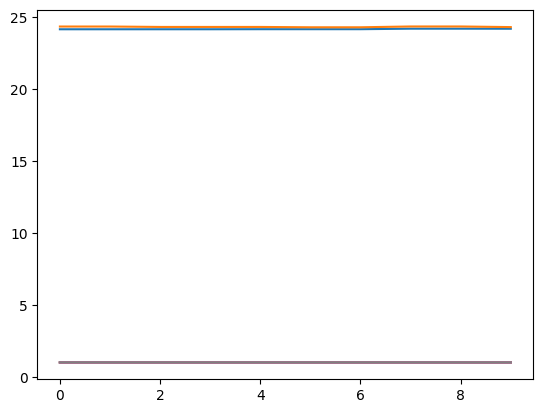

In [743]:
# plt.plot(webtemp_data.transpose()[1:][0][:10].astype(float))

for ch in webtemp_channels:
    plt.plot(ch[:10])

Text(0.5, 0, 'time (hrs)')

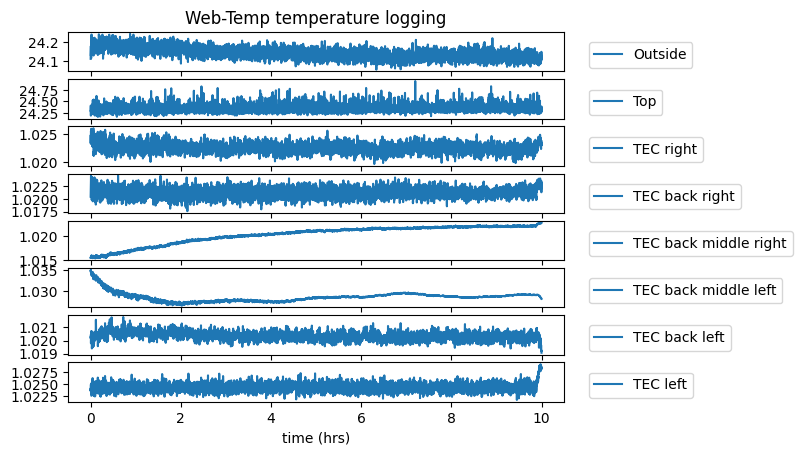

In [755]:
labels = [None]*len(webtemp_channels)
labels[0] = 'Outside'
labels[1] = 'Top'
labels[2]= 'TEC right'
labels[3]= 'TEC back right'
labels[4]= 'TEC back middle right'
labels[5]= 'TEC back middle left'
labels[6]= 'TEC back left'
labels[7]= 'TEC left'

fig,axes = plt.subplots(nrows=len(webtemp_channels),sharex=True)
mod = 10
wt_time = np.linspace(0,10,(wt2-wt1)//mod)
for ax,ch,lbl in zip(axes,webtemp_channels,labels):
    ax.plot(wt_time,[ch[wt1:wt2][i] for i in range(wt2-wt1) if not i%mod],label=lbl)
    ax.legend(loc=(1.05,0.1))
axes[0].set_title('Web-Temp temperature logging')
axes[-1].set_xlabel("time (hrs)")

## 2023.12.13
a more complete study. todo: include logged temperature data, and data from the GOODLogger including Zotino, coil monitors, and magnetometer.

In [335]:
datestr = "2023-12-12\\17\\"
exp_id = '000008582'
imdir = exp_id + '_images'

f = h5py.File(os.path.join(results, datestr, f'{exp_id}-MonitorMOTandExternalBeamPositions.h5'))
counts = np.array(f['datasets']['photocounts'])[1:]

In [337]:
# some of these might be corrupt. "invalid offset to first page 8"
filenames = [
    "MOTExternalBeamPositions.tif",
    "MOTExternalBeamPositions_X2.tif",
    "MOTExternalBeamPositions_X3.tif",
    "MOTExternalBeamPositions_X4.tif",
    "MOTExternalBeamPositions_X5.tif",
    "MOTExternalBeamPositions_X6.tif",
    "MOTExternalBeamPositions_X7.tif",
    "MOTExternalBeamPositions_X8.tif"
]

tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(os.path.join(results,datestr,imdir,f))
    for f in filenames
]))) # flattening tifstackList

<tifffile.TiffPages @8> invalid offset to first page 8


In [338]:
# there should have been twice as many Luca images as ThorCam images, one for each Z beam
# so there is a bug here. it's possible the Luca needs more time between successive images
len(tifstack), len(thor_filenames)

(6514, 3790)

In [349]:
# find the MOT position and half-width along x and y

audit = False # plot a random 5 images and the corresponding fits
thor_filenames = [f for f in next(walk(os.path.join(results,datestr,imdir)), 
                             (None, None, []))[2] if f[-3:]=='bmp']  # [] if no file

n_files = len(thor_filenames)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

xmeans = np.empty(n_files)
ymeans = np.empty(n_files)
xwidths = np.empty(n_files)
ywidths = np.empty(n_files)

# get the dimensions
f = os.path.join(results,datestr,imdir,thor_filenames[0])
im = np.array(Image.open(f).convert('L'))
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)

for i in iterations:
    f = os.path.join(results,datestr,imdir,thor_filenames[i])
    im = np.array(Image.open(f).convert('L'))
    motx = np.sum(im, axis=0).astype(float)
    motx -= np.amin(motx)
    motx /= np.amax(motx)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,700,50,0.1)
    upper_bounds = [1.2,1000,300,5]
    lower_bounds = [0,300,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    xmeans[i] = x0
    xwidths[i] = wx

    moty = np.sum(im, axis=1).astype(float)
    moty -= np.amin(moty)
    moty /= np.amax(moty)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,900,400,0.1)
    upper_bounds = [1.2,1400,1000,0.5]
    lower_bounds = [0,300,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    ymeans[i] = y0
    ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(motx)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(moty)
        plt.plot(model(ypts, *popty))
        plt.show()

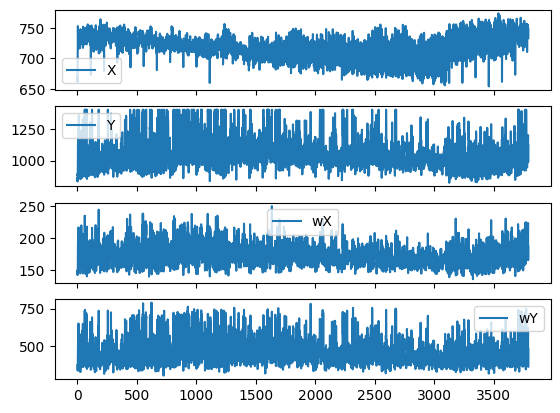

In [284]:
fig,axes = plt.subplots(nrows=4,sharex=True)
ax,ax2,ax3,ax4 = axes
ax.plot(xmeans,label='X')
ax2.plot(ymeans,label='Y')
ax3.plot(xwidths,label='wX')
ax4.plot(ywidths,label='wY')
for ax in axes:
    ax.legend()
# ax3.set_ylim((0,1))

Text(0.5, 0, 'time (s)')

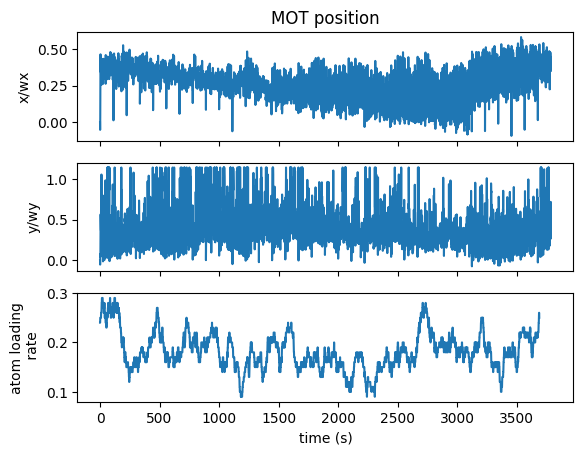

In [286]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=3,sharex=True)
ax,ax2,ax3 = axes
ax.plot((xmeans- xmeans[0])/wx )
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy)
ax2.set_ylabel("y/wy")
ax.set_title("MOT position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'))
ax3.set_ylabel("atom loading\n rate")
ax3.set_xlabel("time (s)")

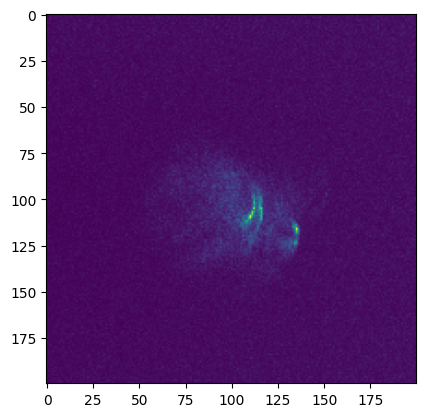

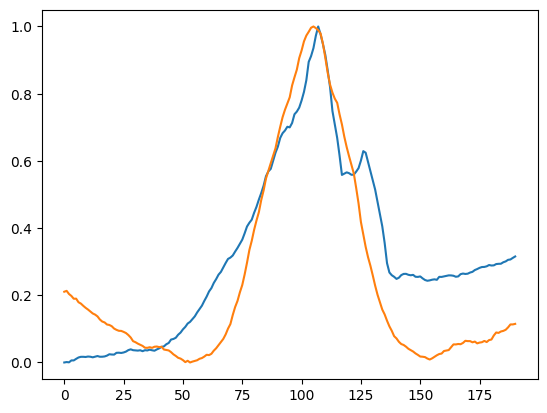

In [226]:
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[100][ymin:ymax,xmin:xmax]
bg = np.mean(im[:20,:20])
sub_im = np.copy(im)
# sub_im[sub_im < np.mean(sub_im)] = 0
plt.imshow(sub_im)
plt.show()
# plt.colorbar()
# cy,cx = ndi.center_of_mass(sub_im)
# print(cy,cx)
# plt.imshow(im)
# plt.scatter([cx],[cy])

mot5x = np.convolve(np.sum(sub_im,axis=0),np.ones(10)/10,'valid')
mot5x -= np.amin(mot5x)
mot5x /= np.amax(mot5x)
mot5y = np.convolve(np.sum(sub_im,axis=1),np.ones(10)/10,'valid')
mot5y -= np.amin(mot5y)
mot5y /= np.amax(mot5y)

plt.plot(mot5x)
plt.plot(mot5y)

In [320]:
audit = False # plot a few random images and the corresponding fits

n_files = len(tifstack)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

mot5xmeans = np.empty(n_files//2)
mot5ymeans = np.empty(n_files//2)
mot5xwidths = np.empty(n_files//2)
mot5ywidths = np.empty(n_files//2)
mot6xmeans = np.empty(n_files//2)
mot6ymeans = np.empty(n_files//2)
mot6xwidths = np.empty(n_files//2)
mot6ywidths = np.empty(n_files//2)

# get the dimensions for our chosen roi
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[0][ymin:ymax,xmin:xmax]
rows, cols = im.shape
xpts = range(cols-(10-1))
ypts = range(rows-(10-1))

for i in iterations:
    im = tifstack[i][ymin:ymax,xmin:xmax]

    if i%2:
        j = (i-1)//2
        
        # mot5x = np.sum(im, axis=0).astype(float)
        mot5x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot5x -= np.amin(mot5x)
        mot5x /= np.amax(mot5x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx5, pcov = curve_fit(model, xpts, mot5x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx5
        mot5xmeans[j] = x0
        mot5xwidths[j] = wx
    
        # mot5y = np.sum(im, axis=1).astype(float)
        mot5y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot5y -= np.amin(mot5y)
        mot5y /= np.amax(mot5y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty5, pcov = curve_fit(model, ypts, mot5y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty5
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot5x)
            plt.plot(model(xpts, *poptx5))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot5y)
            plt.plot(model(ypts, *popty5))
            plt.show()
    
    else:
        j = i//2
        
        # mot6x = np.sum(im, axis=0).astype(float)
        mot6x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot6x -= np.amin(mot6x)
        mot6x /= np.amax(mot6x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx6, pcov = curve_fit(model, xpts, mot6x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx6
        mot6xmeans[j] = x0
        mot6xwidths[j] = wx
    
        # mot6y = np.sum(im, axis=1).astype(float)
        mot6y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot6y -= np.amin(mot6y)
        mot6y /= np.amax(mot6y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty6, pcov = curve_fit(model, ypts, mot6y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty6
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot6x)
            plt.plot(model(xpts, *poptx6))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot6y)
            plt.plot(model(ypts, *popty6))
            plt.show()

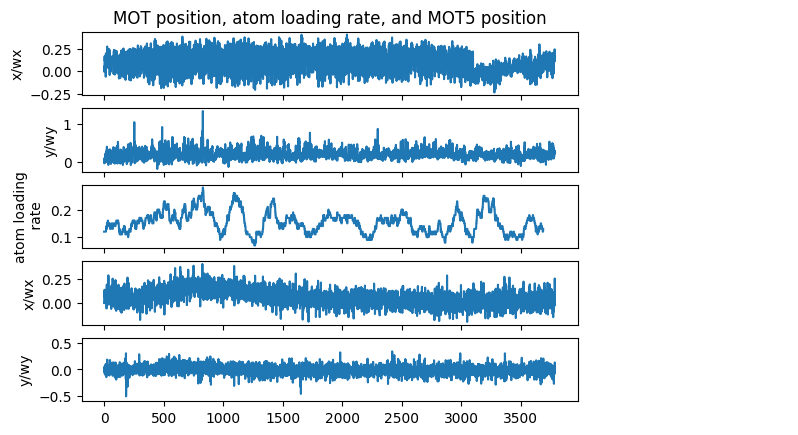

In [445]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot((xmeans- xmeans[0])/wx,label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy,label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot((mot5xmeans - mot5xmeans[0]),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
# ax4.set_ylim((-0.05,0.05))
ax5.plot((mot5ymeans - mot5ymeans[0]),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.6,0.6))
# ax5.set_xlabel("time (s)")
fig.legend(loc=(1.01,0.5))

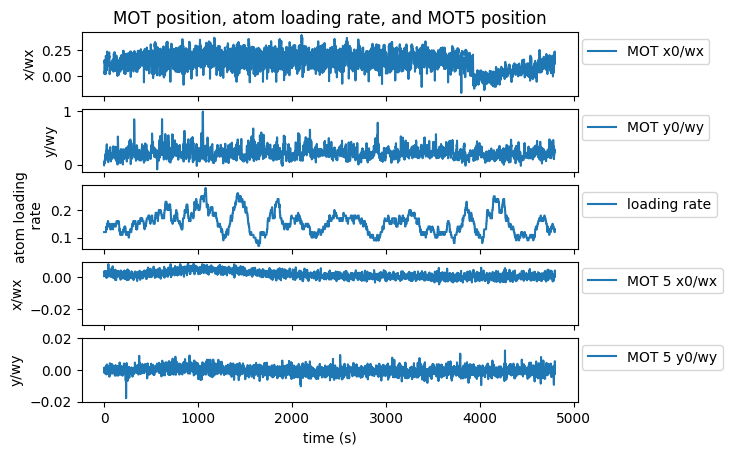

In [444]:
kernel = np.ones(2)/2
roll_avg = lambda data: np.convolve(data, kernel, 'valid')

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)
motxdata = roll_avg((mot5xmeans - mot5xmeans[0])/mot5wx)
time_s = np.linspace(0,4800-1,len(motxdata))

wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot(time_s,roll_avg((xmeans- xmeans[0])/wx),label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot(time_s,roll_avg((ymeans- ymeans[0])/wy),label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
atom_counts = np.convolve(atom,np.ones(100)/100,'valid')

ax3.plot(np.linspace(0,4800-1,len(atom_counts)),atom_counts,label='loading rate')
ax3.set_ylabel("atom loading\n rate")

ax4.plot(time_s,motxdata,label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
ax4.set_ylim((-0.03,0.01))
ax5.plot(time_s,roll_avg((mot5ymeans - mot5ymeans[0])/mot5wy),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.02,0.02))
ax5.set_xlabel("time (s)")
for ax in axes:
    ax.legend(loc=(1.01,0.5))

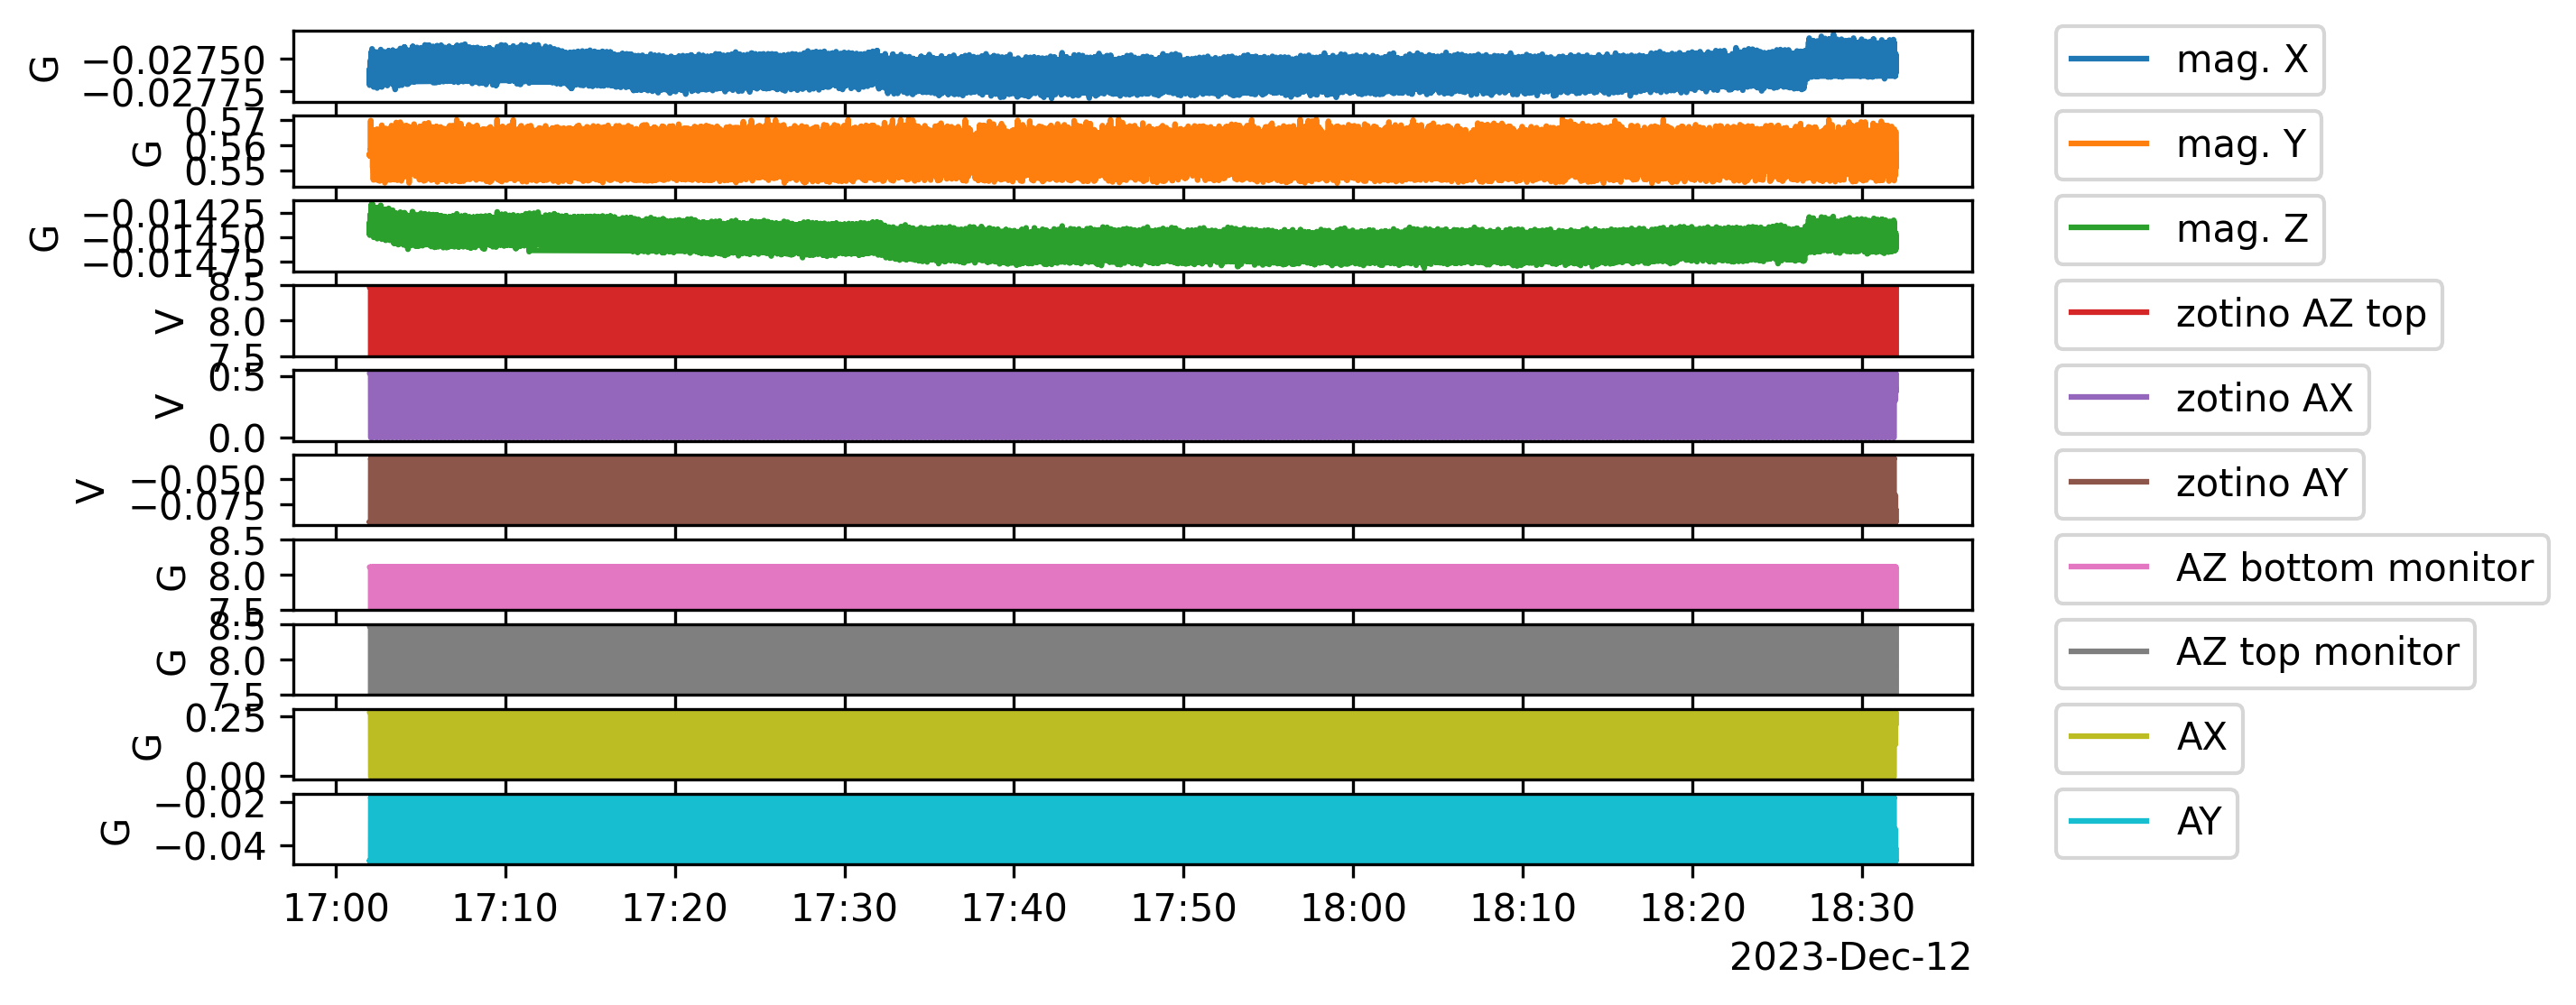

In [365]:
# plot with units G for magnetometer and coil monitor 

roll_avg = lambda data, n: np.convolve(data,np.ones(n)/n,'valid')

labels = ['mag. X','mag. Y','mag. Z','zotino AZ top','zotino AX','zotino AY','AZ bottom monitor','AZ top monitor','AX','AY']
ylabels = ['G','G','G','V','V','V','G','G','G','G']

G_per_V_SM = 1e4*35e-6 # G per T * T per V for Stefan-Mayer FLC3-70
G_per_V_AZ_bottom = 8.75/2 # G per A * A per monitor = V for the AZ top shim coil
G_per_V_AZ_top = 8.75/2 # G per A * A per monitor = V for the AZ top shim coil
G_per_V_AX = 2.27 # G per A * A per monitor = V for the AX shim coil
G_per_V_AY = 2.10 # G per A * A per monitor = V for the AY shim coil

lj_channels = [magX*G_per_V_SM, magY*G_per_V_SM, magZ*G_per_V_SM, 
            zotAZtop, zotAX, zotAY, 
            monitorAZbottom*G_per_V_AZ_bottom, monitorAZtop*G_per_V_AZ_top, monitorAX*G_per_V_AX, monitorAY*G_per_V_AY]

avgs = 10

colors = plt.rcParams["axes.prop_cycle"]()
fig,axes = plt.subplots(nrows=len(lj_channels),sharex=True, constrained_layout=False,dpi=300,figsize=(8,4))
ch_i = 0
for ax,ch,lbl,ylbl in zip(axes,lj_channels,labels,ylabels):
    c = next(colors)["color"]
    ax.plot(datetimes[:-(avgs-1)],roll_avg(ch,avgs),label=lbl,color=c)
    ax.set_ylabel(ylbl)
    ax.legend(loc=(1.05,0.1))
    ch_i += 1

axes[3].set_ylim((7.5,8.5))
axes[6].set_ylim((7.5,8.5))
axes[7].set_ylim((7.5,8.5))
plt.show()
# plt.savefig('magnetometer_zotino_coilmonitor_data_20231012.png',bbox_inches='tight')


(8.44, 8.5)

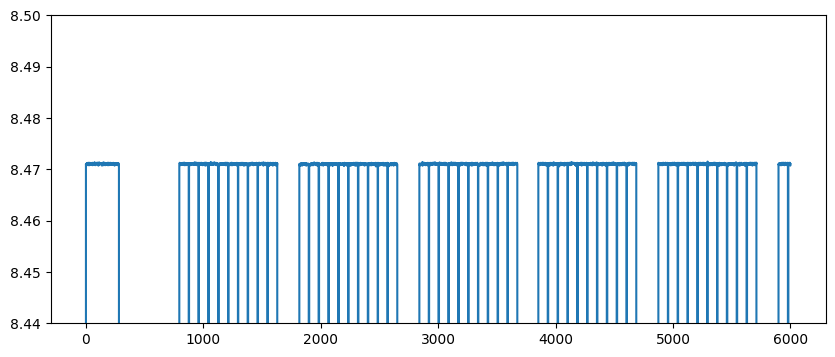

In [373]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(range(100*60),zotAZtop[:100*60])
# ax.plot(range(100*60),zotAZtop[:100*60])
ax.set_ylim((8.44,8.5))

In [ ]:
x = np.linspace(0,10,100)

points_per_s = 79.88520833333334 # estimate from dividing length of data by seconds passed

seconds = 20 # per section
offset = int(6*3000*seconds) #4800//2 in seconds

ylims = [None]*len(lj_channels)
ylims[1] = (0.5,0.7)
ylims[3] = (8.46, 8.48)
ylims[4] = (0.5, 0.55)
ylims[5] = (-0.1, -0.028)
ylims[6] = (8.1, 8.25)
ylims[7] = (8.46, 8.5)
ylims[-1] = (-0.05,-0.04)


for ax,ch,lbl,ylbl,ylim in zip(axes,lj_channels,labels,ylabels,ylims):
    c = next(colors)["color"]
    # ax.plot(datetimes[:-(avgs-1)],roll_avg(ch,avgs),label=lbl,color=c)
    ax.set_ylabel(ylbl)
    ax.legend(loc=(1.05,0.1))
    ch_i += 1

    data = ch
    ndata = len(ch)
    x = np.linspace(0,ndata,ndata-1)/points_per_s
    y = data
        
    f, (ax, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, facecolor='w', figsize=(10,3))
    
    # plot the same data on both axes
    ax.plot(x[:100*seconds], y[:100*seconds],color=c)
    ax.set_title(lbl)
    ax.set_ylabel(ylbl)
    ax2.plot(x[offset:offset+100*seconds], y[offset:offset+100*seconds],color=c)
    ax3.plot(x[-100*seconds:], y[-100*seconds:],color=c)
    
    ax.set_xlim((0, 100*seconds/points_per_s))
    ax2.set_xlim((offset/points_per_s, (offset+100*seconds)/points_per_s))
    ax3.set_xlim(((ndata - 100*seconds - 1)/points_per_s, (ndata-1)/points_per_s))
    
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
    
    # hide the spines between ax2 and ax3
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax2.yaxis.tick_left()
    ax2.tick_params(labelright='off')
    ax3.yaxis.tick_right()
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
    ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')

    if ylim != None:
        ax.set_ylim(ylim)
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)
    else:
        ylim = (0.9*np.max(data),1.1*np.max(data))
        ax.set_ylim(ylim)
        ax2.set_ylim(ylim)
        ax3.set_ylim(ylim)

In [422]:
# get data from Web-Temp temperature logger

webtemp_data =  []
with open(os.path.join(results, datestr, imdir, 'webtemp_data_2023-12-12.csv')) as f:
    reader = csv.reader(f)
    header = reader.__next__()    
    header = reader.__next__()
    for row in reader:
        try:
            webtemp_data.append([row[0]]+[float(x) for x in row[1:]])
        except ValueError:
            print(row)
            break
webtemp_data = np.array(webtemp_data)

In [423]:
header

['Time',
 'CHANNEL0',
 'CHANNEL1',
 'CHANNEL2',
 'CHANNEL3',
 'CHANNEL4',
 'CHANNEL5',
 'CHANNEL6',
 'CHANNEL7']

In [424]:
rows = webtemp_data.transpose()
time = rows[0]
tc_channels = rows[1:]

In [433]:
time[0], time[-1]

('2023-12-12_18:04:12', '2023-12-13_20:11:13')

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001C86E38E4C0>
Traceback (most recent call last):
  File "c:\python39\lib\weakref.py", line 368, in remove
    self = selfref()
KeyboardInterrupt: 


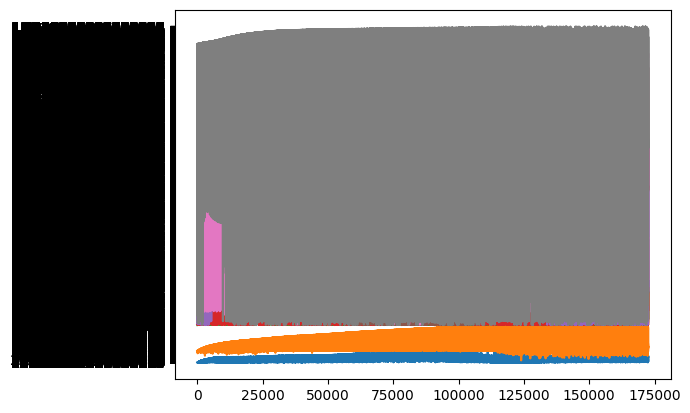

In [425]:
for ch in tc_channels:
    plt.plot(ch)

## 2023.12.12a

In [273]:
datestr = "2023-12-12\\11\\"
exp_id = '000008574'
imdir = exp_id + '_images'

# f = h5py.File(os.path.join(results, datestr, f'{exp_id}-MonitorMOTandExternalBeamPositions.h5'))
# counts = np.array(f['datasets']['photocounts'])[1:]

counts = []
with open(os.path.join(results, datestr, imdir, 'counts.csv')) as f:
    reader = csv.reader(f)
    header = reader.__next__()
    for row in reader:
        counts.append(float(row[1]))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   3.,  15.,  35., 141., 210.,
        463., 443., 564., 496., 286., 201.,  87.,  59.,  32.,  45.,  49.,
         41.,  78.,  60.,  72.,  77.,  65.,  88.,  42.,  56.,  31.,  21.,
         12.,   8.,   4.,   2.,   2.,   1.]),
 array([  0.  ,   5.58,  11.16,  16.74,  22.32,  27.9 ,  33.48,  39.06,
         44.64,  50.22,  55.8 ,  61.38,  66.96,  72.54,  78.12,  83.7 ,
         89.28,  94.86, 100.44, 106.02, 111.6 , 117.18, 122.76, 128.34,
        133.92, 139.5 , 145.08, 150.66, 156.24, 161.82, 167.4 , 172.98,
        178.56, 184.14, 189.72, 195.3 , 200.88, 206.46, 212.04, 217.62,
        223.2 , 228.78, 234.36, 239.94, 245.52, 251.1 , 256.68, 262.26,
        267.84, 273.42, 279.  ]),
 <BarContainer object of 50 artists>)

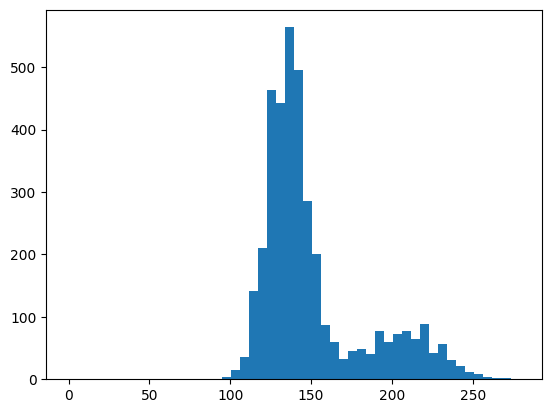

In [274]:
plt.hist(counts,bins=50)

In [276]:
filenames = [
    "MOTExternalBeamPositions.tif",
    "MOTExternalBeamPositions_X2.tif",
    "MOTExternalBeamPositions_X3.tif",
    "MOTExternalBeamPositions_X4.tif",
    "MOTExternalBeamPositions_X5.tif",
    "MOTExternalBeamPositions_X6.tif",
    "MOTExternalBeamPositions_X7.tif",
    "MOTExternalBeamPositions_X8.tif"
]

tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(os.path.join(results,datestr,imdir,f))
    for f in filenames
]))) # flattening tifstackList

In [277]:
# there should have been twice as many Luca images as ThorCam images, one for each Z beam
# so there is a bug here. it's possible the Luca needs more time between successive images
len(tifstack), len(thor_filenames)

(7580, 3789)

In [283]:
audit = False # plot a random 5 images and the corresponding fits
thor_filenames = [f for f in next(walk(os.path.join(results,datestr,imdir)), 
                             (None, None, []))[2] if f[-3:]=='bmp']  # [] if no file

n_files = len(thor_filenames)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

xmeans = np.empty(n_files)
ymeans = np.empty(n_files)
xwidths = np.empty(n_files)
ywidths = np.empty(n_files)

# get the dimensions
f = os.path.join(results,datestr,imdir,thor_filenames[0])
im = np.array(Image.open(f).convert('L'))
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)

for i in iterations:
    f = os.path.join(results,datestr,imdir,thor_filenames[i])
    im = np.array(Image.open(f).convert('L'))
    motx = np.sum(im, axis=0).astype(float)
    motx -= np.amin(motx)
    motx /= np.amax(motx)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,700,50,0.1)
    upper_bounds = [1.2,1000,300,5]
    lower_bounds = [0,300,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    xmeans[i] = x0
    xwidths[i] = wx

    moty = np.sum(im, axis=1).astype(float)
    moty -= np.amin(moty)
    moty /= np.amax(moty)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,900,400,0.1)
    upper_bounds = [1.2,1400,1000,0.5]
    lower_bounds = [0,300,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    ymeans[i] = y0
    ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(motx)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(moty)
        plt.plot(model(ypts, *popty))
        plt.show()

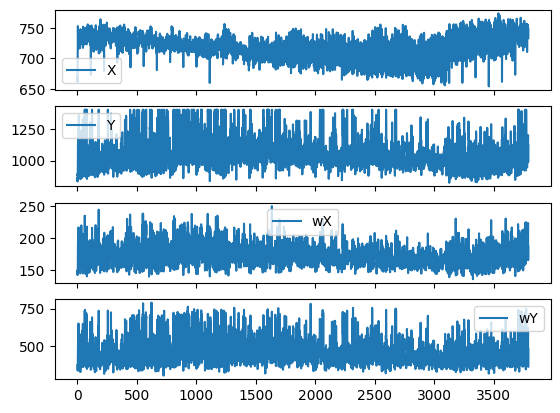

In [284]:
fig,axes = plt.subplots(nrows=4,sharex=True)
ax,ax2,ax3,ax4 = axes
ax.plot(xmeans,label='X')
ax2.plot(ymeans,label='Y')
ax3.plot(xwidths,label='wX')
ax4.plot(ywidths,label='wY')
for ax in axes:
    ax.legend()
# ax3.set_ylim((0,1))

Text(0.5, 0, 'time (s)')

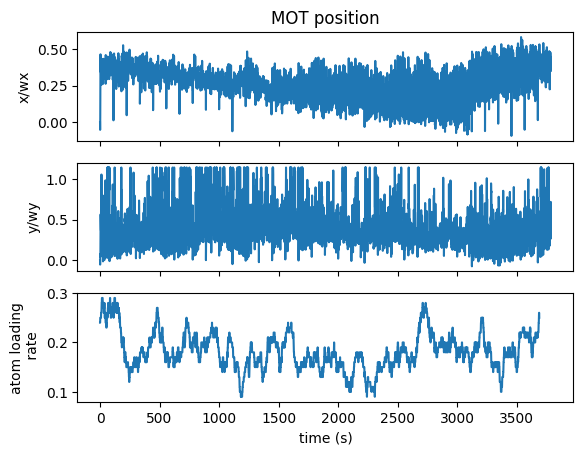

In [286]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=3,sharex=True)
ax,ax2,ax3 = axes
ax.plot((xmeans- xmeans[0])/wx )
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy)
ax2.set_ylabel("y/wy")
ax.set_title("MOT position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'))
ax3.set_ylabel("atom loading\n rate")
ax3.set_xlabel("time (s)")

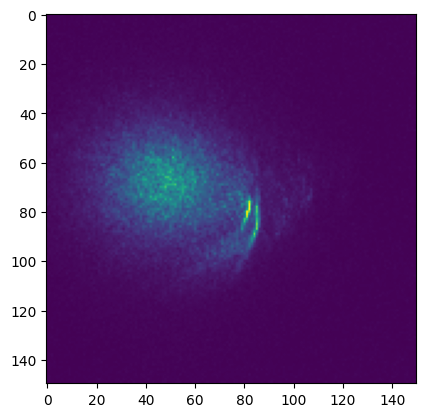

In [298]:
plt.imshow(tifstack[1001][350:500,130:280])

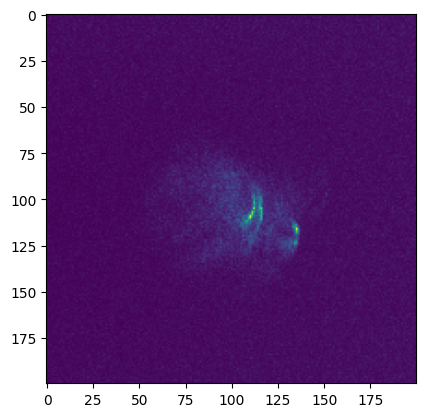

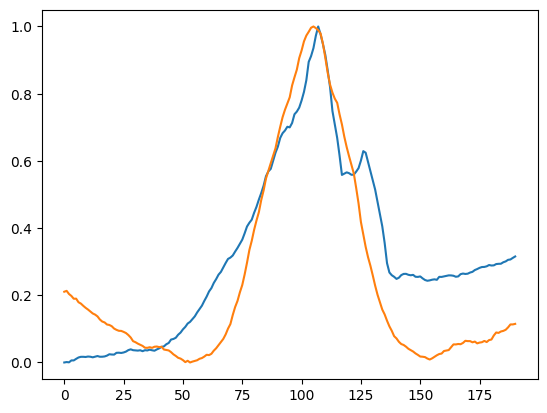

In [226]:
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[100][ymin:ymax,xmin:xmax]
bg = np.mean(im[:20,:20])
sub_im = np.copy(im)
# sub_im[sub_im < np.mean(sub_im)] = 0
plt.imshow(sub_im)
plt.show()
# plt.colorbar()
# cy,cx = ndi.center_of_mass(sub_im)
# print(cy,cx)
# plt.imshow(im)
# plt.scatter([cx],[cy])

mot5x = np.convolve(np.sum(sub_im,axis=0),np.ones(10)/10,'valid')
mot5x -= np.amin(mot5x)
mot5x /= np.amax(mot5x)
mot5y = np.convolve(np.sum(sub_im,axis=1),np.ones(10)/10,'valid')
mot5y -= np.amin(mot5y)
mot5y /= np.amax(mot5y)

plt.plot(mot5x)
plt.plot(mot5y)

In [316]:
[(i-1)//2 if i%2 else i//2 for i in range(10)]

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

In [295]:
len(np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid'))

191

In [296]:
len(np.sum(im,axis=0))

200

In [320]:
audit = False # plot a few random images and the corresponding fits

n_files = len(tifstack)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

mot5xmeans = np.empty(n_files//2)
mot5ymeans = np.empty(n_files//2)
mot5xwidths = np.empty(n_files//2)
mot5ywidths = np.empty(n_files//2)
mot6xmeans = np.empty(n_files//2)
mot6ymeans = np.empty(n_files//2)
mot6xwidths = np.empty(n_files//2)
mot6ywidths = np.empty(n_files//2)

# get the dimensions for our chosen roi
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[0][ymin:ymax,xmin:xmax]
rows, cols = im.shape
xpts = range(cols-(10-1))
ypts = range(rows-(10-1))

for i in iterations:
    im = tifstack[i][ymin:ymax,xmin:xmax]

    if i%2:
        j = (i-1)//2
        
        # mot5x = np.sum(im, axis=0).astype(float)
        mot5x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot5x -= np.amin(mot5x)
        mot5x /= np.amax(mot5x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx5, pcov = curve_fit(model, xpts, mot5x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx5
        mot5xmeans[j] = x0
        mot5xwidths[j] = wx
    
        # mot5y = np.sum(im, axis=1).astype(float)
        mot5y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot5y -= np.amin(mot5y)
        mot5y /= np.amax(mot5y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty5, pcov = curve_fit(model, ypts, mot5y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty5
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot5x)
            plt.plot(model(xpts, *poptx5))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot5y)
            plt.plot(model(ypts, *popty5))
            plt.show()
    
    else:
        j = i//2
        
        # mot6x = np.sum(im, axis=0).astype(float)
        mot6x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
        mot6x -= np.amin(mot6x)
        mot6x /= np.amax(mot6x)
        
        # amplitude, mean x, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # xfit
        poptx6, pcov = curve_fit(model, xpts, mot6x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, x0, wx, b = poptx6
        mot6xmeans[j] = x0
        mot6xwidths[j] = wx
    
        # mot6y = np.sum(im, axis=1).astype(float)
        mot6y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid')
        mot6y -= np.amin(mot6y)
        mot6y /= np.amax(mot6y)
        
        # amplitude, mean y, 1/e width, offset (background)
        initial_guess = (1,100,50,0.1)
        upper_bounds = [1.2,170,300,1]
        lower_bounds = [0,20,5,0]
    
        # yfit
        popty6, pcov = curve_fit(model, ypts, mot6y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
        a, y0, wy, b = popty6
        mot5ymeans[j] = y0
        mot5ywidths[j] = wy

        if audit:
            plt.title(f"experiment iteration {j}")
            plt.imshow(im)
            plt.show()
            plt.title(f"wx={wx:.2f},x0={x0:.2f}")
            plt.plot(mot6x)
            plt.plot(model(xpts, *poptx6))
            plt.show()
            plt.title(f"wy={wy:.2f},y0={y0:.2f}")
            plt.plot(mot6y)
            plt.plot(model(ypts, *popty6))
            plt.show()

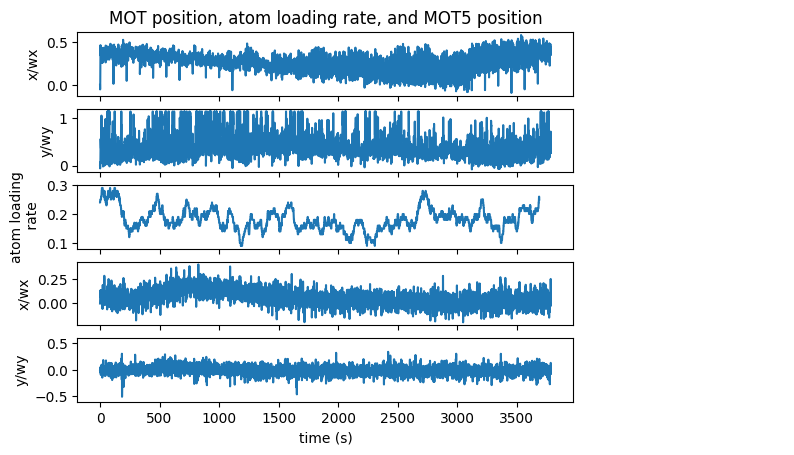

In [330]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot((xmeans- xmeans[0])/wx,label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy,label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot((mot5xmeans - mot5xmeans[0]),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
# ax4.set_ylim((-0.05,0.05))
ax5.plot((mot5ymeans - mot5ymeans[0]),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.6,0.6))
ax5.set_xlabel("time (s)")
fig.legend(loc=(1.01,0.5))

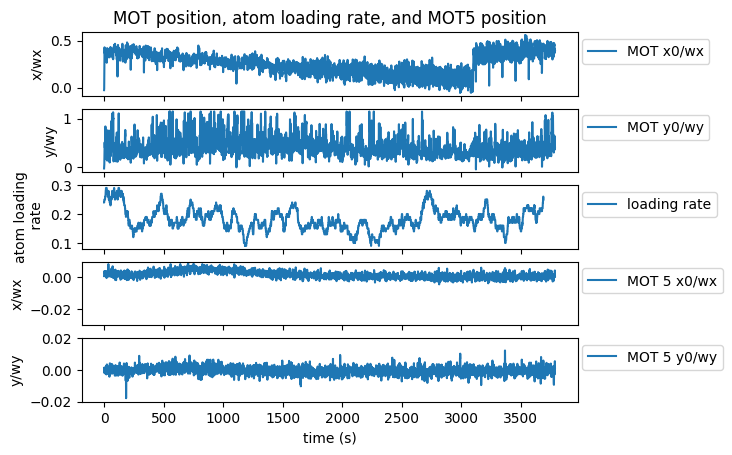

In [332]:
kernel = np.ones(2)/2
roll_avg = lambda data: np.convolve(data, kernel, 'valid')

wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot(roll_avg((xmeans- xmeans[0])/wx),label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot(roll_avg((ymeans- ymeans[0])/wy),label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot(roll_avg((mot5xmeans - mot5xmeans[0])/mot5wx),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
ax4.set_ylim((-0.03,0.01))
ax5.plot(roll_avg((mot5ymeans - mot5ymeans[0])/mot5wy),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.02,0.02))
ax5.set_xlabel("time (s)")
for ax in axes:
    ax.legend(loc=(1.01,0.5))

## 2023.12.12b

### import data - only MOT6
I incorrectly labeled it as MOT5 in the variables and plots below.

In [146]:
datestr = "2023-12-11\\12\\"
imdir = '000008536_images'

f = h5py.File(os.path.join(results, datestr, '000008536-MonitorMOTandExternalBeamPositions.h5'))
counts = np.array(f['datasets']['photocounts'])[1:]

In [256]:
filenames = [
    "C:\\Users\\QC\OneDrive - UW-Madison\\Pictures\\Andor Luca images\\MOTExternalBeamPositions.tif"
]
tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(f)
    for f in filenames
]))) # flattening tifstackList

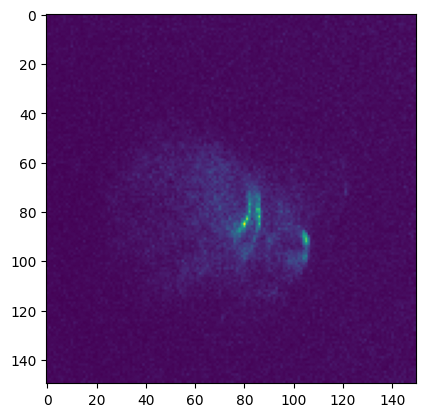

In [257]:
plt.imshow(tifstack[0][350:500,130:280])

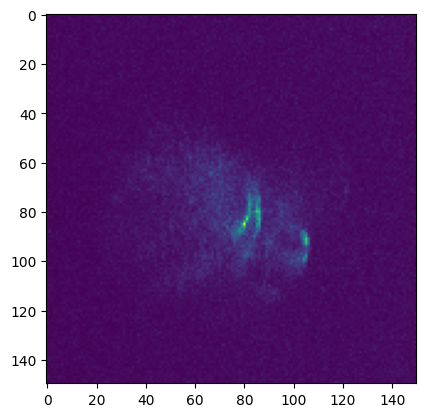

In [258]:
plt.imshow(tifstack[1][350:500,130:280])

In [148]:
filenames = [
    "MOTExternalBeamPositions.tif",
    "MOTExternalBeamPositions_X2.tif",
    "MOTExternalBeamPositions_X3.tif",
    "MOTExternalBeamPositions_X4.tif"
]

tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(os.path.join(results,datestr,imdir,f))
    for f in filenames
]))) # flattening tifstackList

In [154]:
# there should have been twice as many Luca images as ThorCam images, one for each Z beam
# so there is a bug here. it's possible the Luca needs more time between successive images
len(tifstack), len(thor_filenames)

(3789, 3789)

In [124]:
audit = False # plot a random 5 images and the corresponding fits
thor_filenames = [f for f in next(walk(os.path.join(results,datestr,imdir)), 
                             (None, None, []))[2] if f[-3:]=='bmp']  # [] if no file

n_files = len(thor_filenames)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

xmeans = np.empty(n_files)
ymeans = np.empty(n_files)
xwidths = np.empty(n_files)
ywidths = np.empty(n_files)

# get the dimensions
f = os.path.join(results,datestr,imdir,thor_filenames[0])
im = np.array(Image.open(f).convert('L'))
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)

for i in iterations:
    f = os.path.join(results,datestr,imdir,thor_filenames[i])
    im = np.array(Image.open(f).convert('L'))
    motx = np.sum(im, axis=0).astype(float)
    motx -= np.amin(motx)
    motx /= np.amax(motx)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,700,50,0.1)
    upper_bounds = [1.2,1000,300,5]
    lower_bounds = [0,300,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    xmeans[i] = x0
    xwidths[i] = wx

    moty = np.sum(im, axis=1).astype(float)
    moty -= np.amin(moty)
    moty /= np.amax(moty)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,900,400,0.1)
    upper_bounds = [1.2,1000,1000,0.5]
    lower_bounds = [0,300,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    ymeans[i] = y0
    ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(motx)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(moty)
        plt.plot(model(ypts, *popty))
        plt.show()

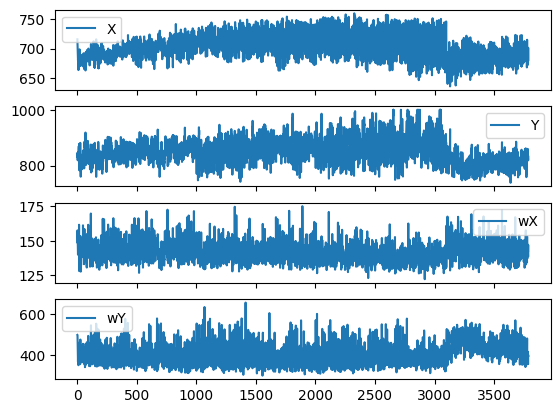

In [125]:
fig,axes = plt.subplots(nrows=4,sharex=True)
ax,ax2,ax3,ax4 = axes
ax.plot(xmeans,label='X')
ax2.plot(ymeans,label='Y')
ax3.plot(xwidths,label='wX')
ax4.plot(ywidths,label='wY')
for ax in axes:
    ax.legend()
# ax3.set_ylim((0,1))

Text(0.5, 0, 'time (s)')

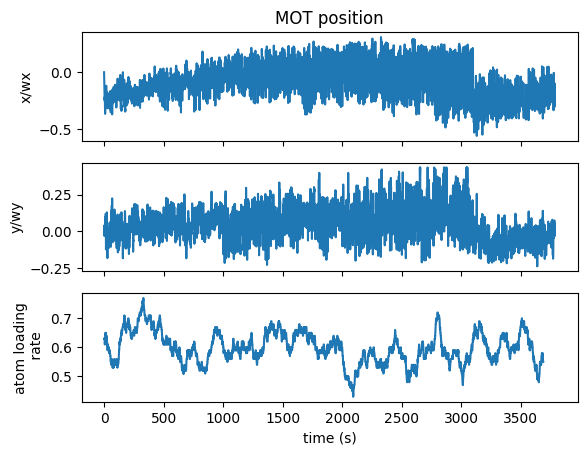

In [144]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=3,sharex=True)
ax,ax2,ax3 = axes
ax.plot((xmeans- xmeans[0])/wx )
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy)
ax2.set_ylabel("y/wy")
ax.set_title("MOT position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'))
ax3.set_ylabel("atom loading\n rate")
ax3.set_xlabel("time (s)")

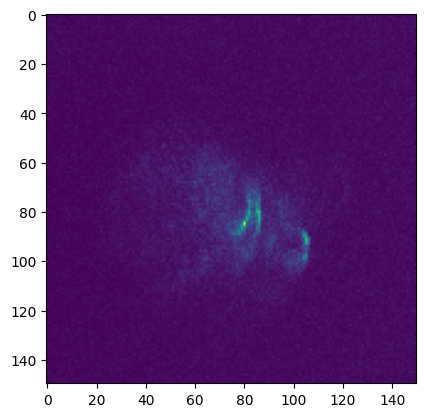

In [166]:
plt.imshow(tifstack[1000][350:500,130:280])

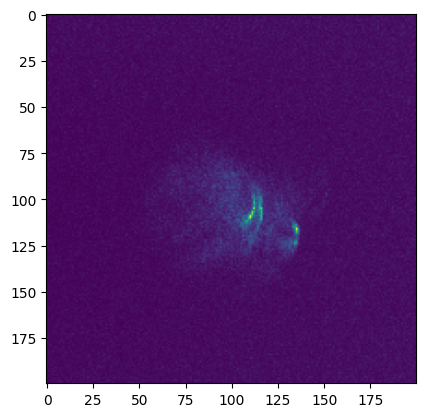

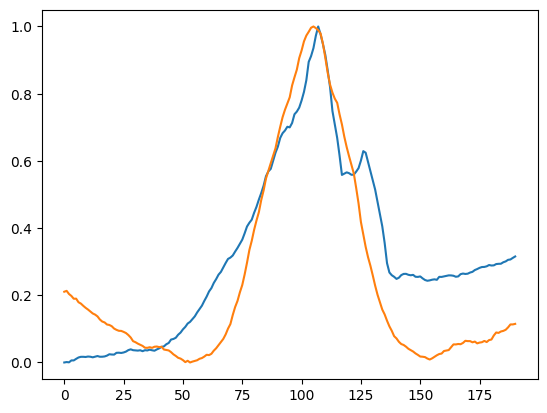

In [226]:
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[100][ymin:ymax,xmin:xmax]
bg = np.mean(im[:20,:20])
sub_im = np.copy(im)
# sub_im[sub_im < np.mean(sub_im)] = 0
plt.imshow(sub_im)
plt.show()
# plt.colorbar()
# cy,cx = ndi.center_of_mass(sub_im)
# print(cy,cx)
# plt.imshow(im)
# plt.scatter([cx],[cy])

mot5x = np.convolve(np.sum(sub_im,axis=0),np.ones(10)/10,'valid')
mot5x -= np.amin(mot5x)
mot5x /= np.amax(mot5x)
mot5y = np.convolve(np.sum(sub_im,axis=1),np.ones(10)/10,'valid')
mot5y -= np.amin(mot5y)
mot5y /= np.amax(mot5y)

plt.plot(mot5x)
plt.plot(mot5y)

In [252]:
audit = False # plot a random 5 images and the corresponding fits

n_files = len(tifstack)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

mot5xmeans = np.empty(n_files)
mot5ymeans = np.empty(n_files)
mot5xwidths = np.empty(n_files)
mot5ywidths = np.empty(n_files)

# get the dimensions for our chosen roi
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[0][ymin:ymax,xmin:xmax]
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)
# xpts = len(np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid'))#range(cols)
# ypts = len(np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid'))#range(rows)

for i in iterations:
    im = tifstack[i][ymin:ymax,xmin:xmax]
    mot5x = np.sum(im, axis=0).astype(float)
    # mot5x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
    mot5x -= np.amin(mot5x)
    mot5x /= np.amax(mot5x)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,100,50,0.1)
    upper_bounds = [1.2,170,300,1]
    lower_bounds = [0,20,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, mot5x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    mot5xmeans[i] = x0
    mot5xwidths[i] = wx

    mot5y = np.sum(im, axis=1).astype(float)
    # mot5y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid') #np.sum(im, axis=1).astype(float)
    mot5y -= np.amin(mot5y)
    mot5y /= np.amax(mot5y)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,100,50,0.1)
    upper_bounds = [1.2,170,300,1]
    lower_bounds = [0,20,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, mot5y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    mot5ymeans[i] = y0
    mot5ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(mot5x)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(mot5y)
        plt.plot(model(ypts, *popty))
        plt.show()

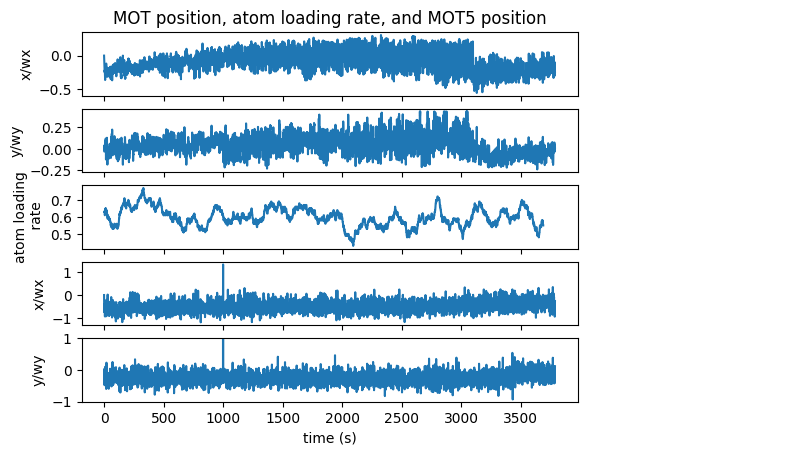

In [255]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot((xmeans- xmeans[0])/wx,label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy,label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot((mot5xmeans - mot5xmeans[0]),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
# ax4.set_ylim((-0.05,0.05))
ax5.plot((mot5ymeans - mot5ymeans[0]),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-1,1))
ax5.set_xlabel("time (s)")
fig.legend(loc=(1.01,0.5))

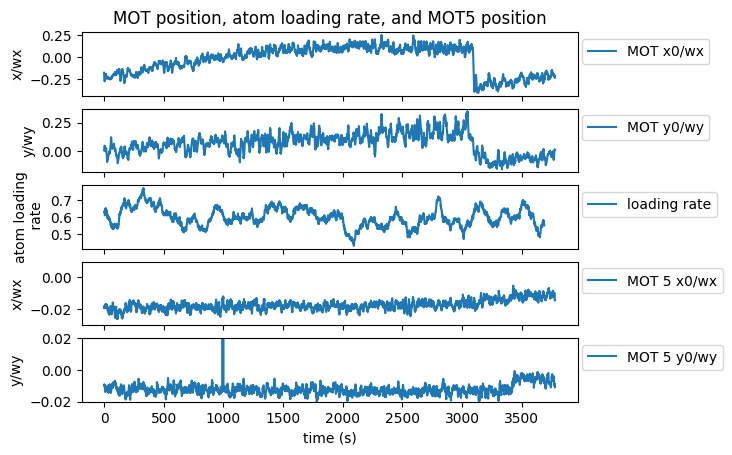

In [250]:
kernel = np.ones(10)/10
roll_avg = lambda data: np.convolve(data, kernel, 'valid')

wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot(roll_avg((xmeans- xmeans[0])/wx),label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot(roll_avg((ymeans- ymeans[0])/wy),label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot(roll_avg((mot5xmeans - mot5xmeans[0])/mot5wx),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
ax4.set_ylim((-0.03,0.01))
ax5.plot(roll_avg((mot5ymeans - mot5ymeans[0])/mot5wy),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.02,0.02))
ax5.set_xlabel("time (s)")
for ax in axes:
    ax.legend(loc=(1.01,0.5))

## 2023.12.11-12

### import data

In [146]:
datestr = "2023-12-11\\12\\"
imdir = '000008536_images'

f = h5py.File(os.path.join(results, datestr, '000008536-MonitorMOTandExternalBeamPositions.h5'))
counts = np.array(f['datasets']['photocounts'])[1:]

In [148]:
filenames = [
    "MOTExternalBeamPositions.tif",
    "MOTExternalBeamPositions_X2.tif",
    "MOTExternalBeamPositions_X3.tif",
    "MOTExternalBeamPositions_X4.tif"
]

tifstack = np.array(list(itertools.chain(
    *[tifffile.imread(os.path.join(results,datestr,imdir,f))
    for f in filenames
]))) # flattening tifstackList

In [154]:
# there should have been twice as many Luca images as ThorCam images, one for each Z beam
# so there is a bug here. it's possible the Luca needs more time between successive images
len(tifstack), len(thor_filenames)

(3789, 3789)

In [124]:
audit = False # plot a random 5 images and the corresponding fits
thor_filenames = [f for f in next(walk(os.path.join(results,datestr,imdir)), 
                             (None, None, []))[2] if f[-3:]=='bmp']  # [] if no file

n_files = len(thor_filenames)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

xmeans = np.empty(n_files)
ymeans = np.empty(n_files)
xwidths = np.empty(n_files)
ywidths = np.empty(n_files)

# get the dimensions
f = os.path.join(results,datestr,imdir,thor_filenames[0])
im = np.array(Image.open(f).convert('L'))
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)

for i in iterations:
    f = os.path.join(results,datestr,imdir,thor_filenames[i])
    im = np.array(Image.open(f).convert('L'))
    motx = np.sum(im, axis=0).astype(float)
    motx -= np.amin(motx)
    motx /= np.amax(motx)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,700,50,0.1)
    upper_bounds = [1.2,1000,300,5]
    lower_bounds = [0,300,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, motx, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    xmeans[i] = x0
    xwidths[i] = wx

    moty = np.sum(im, axis=1).astype(float)
    moty -= np.amin(moty)
    moty /= np.amax(moty)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,900,400,0.1)
    upper_bounds = [1.2,1000,1000,0.5]
    lower_bounds = [0,300,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, moty, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    ymeans[i] = y0
    ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(motx)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(moty)
        plt.plot(model(ypts, *popty))
        plt.show()

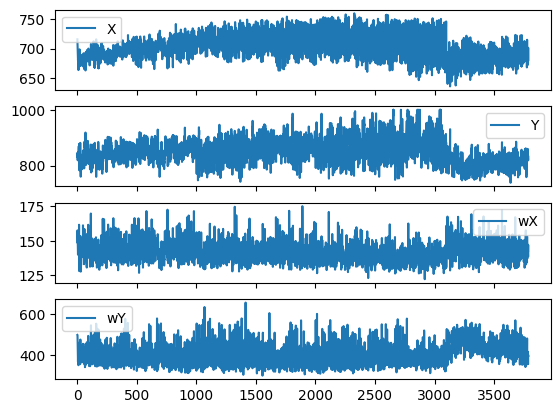

In [125]:
fig,axes = plt.subplots(nrows=4,sharex=True)
ax,ax2,ax3,ax4 = axes
ax.plot(xmeans,label='X')
ax2.plot(ymeans,label='Y')
ax3.plot(xwidths,label='wX')
ax4.plot(ywidths,label='wY')
for ax in axes:
    ax.legend()
# ax3.set_ylim((0,1))

Text(0.5, 0, 'time (s)')

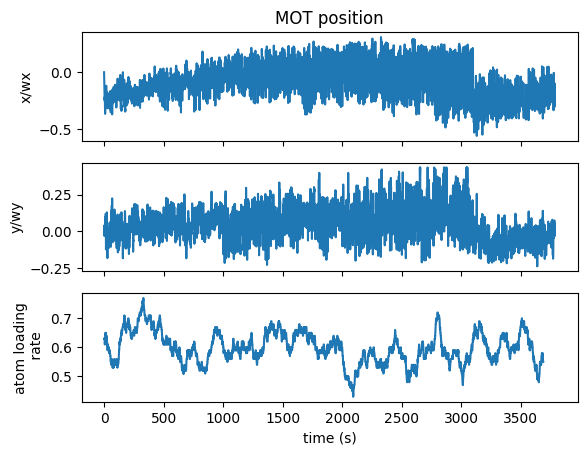

In [144]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=3,sharex=True)
ax,ax2,ax3 = axes
ax.plot((xmeans- xmeans[0])/wx )
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy)
ax2.set_ylabel("y/wy")
ax.set_title("MOT position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'))
ax3.set_ylabel("atom loading\n rate")
ax3.set_xlabel("time (s)")

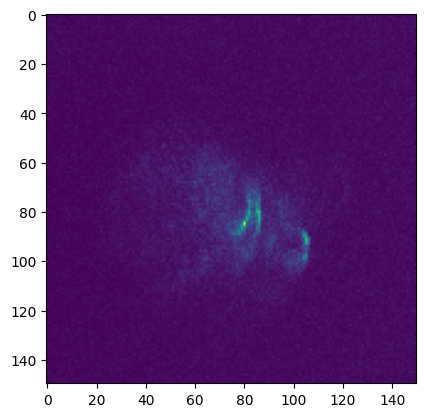

In [166]:
plt.imshow(tifstack[1000][350:500,130:280])

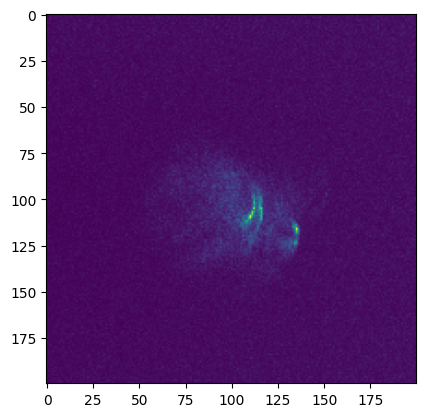

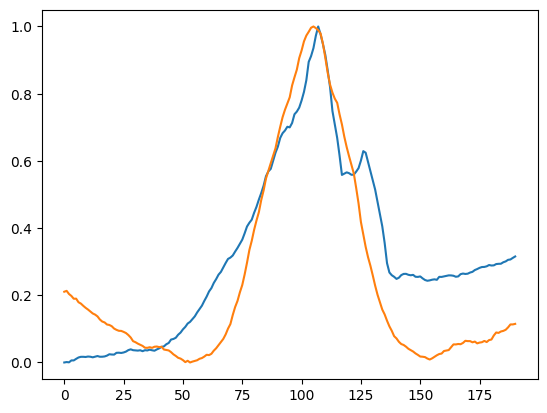

In [226]:
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[100][ymin:ymax,xmin:xmax]
bg = np.mean(im[:20,:20])
sub_im = np.copy(im)
# sub_im[sub_im < np.mean(sub_im)] = 0
plt.imshow(sub_im)
plt.show()
# plt.colorbar()
# cy,cx = ndi.center_of_mass(sub_im)
# print(cy,cx)
# plt.imshow(im)
# plt.scatter([cx],[cy])

mot5x = np.convolve(np.sum(sub_im,axis=0),np.ones(10)/10,'valid')
mot5x -= np.amin(mot5x)
mot5x /= np.amax(mot5x)
mot5y = np.convolve(np.sum(sub_im,axis=1),np.ones(10)/10,'valid')
mot5y -= np.amin(mot5y)
mot5y /= np.amax(mot5y)

plt.plot(mot5x)
plt.plot(mot5y)

In [252]:
audit = False # plot a random 5 images and the corresponding fits

n_files = len(tifstack)

if audit:
    iterations = np.random.randint(0,n_files,5)
else:
    iterations = range(n_files)

def model(x, a, x0, w0, b):
    return a*np.exp(-((x-x0)/w0)**2) + b

mot5xmeans = np.empty(n_files)
mot5ymeans = np.empty(n_files)
mot5xwidths = np.empty(n_files)
mot5ywidths = np.empty(n_files)

# get the dimensions for our chosen roi
xmin,xmax=100,300
ymin,ymax=325,525
im = tifstack[0][ymin:ymax,xmin:xmax]
rows, cols = im.shape
xpts = range(cols)
ypts = range(rows)
# xpts = len(np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid'))#range(cols)
# ypts = len(np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid'))#range(rows)

for i in iterations:
    im = tifstack[i][ymin:ymax,xmin:xmax]
    mot5x = np.sum(im, axis=0).astype(float)
    # mot5x = np.convolve(np.sum(im,axis=0),np.ones(10)/10,'valid')
    mot5x -= np.amin(mot5x)
    mot5x /= np.amax(mot5x)
    
    # amplitude, mean x, 1/e width, offset (background)
    initial_guess = (1,100,50,0.1)
    upper_bounds = [1.2,170,300,1]
    lower_bounds = [0,20,5,0]

    # xfit
    poptx, pcov = curve_fit(model, xpts, mot5x, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, x0, wx, b = poptx
    mot5xmeans[i] = x0
    mot5xwidths[i] = wx

    mot5y = np.sum(im, axis=1).astype(float)
    # mot5y = np.convolve(np.sum(im,axis=1),np.ones(10)/10,'valid') #np.sum(im, axis=1).astype(float)
    mot5y -= np.amin(mot5y)
    mot5y /= np.amax(mot5y)
    
    # amplitude, mean y, 1/e width, offset (background)
    initial_guess = (1,100,50,0.1)
    upper_bounds = [1.2,170,300,1]
    lower_bounds = [0,20,5,0]

    # yfit
    popty, pcov = curve_fit(model, ypts, mot5y, p0=initial_guess, bounds=[lower_bounds,upper_bounds])
    a, y0, wy, b = popty
    mot5ymeans[i] = y0
    mot5ywidths[i] = wy

    if audit:
        plt.title(f"experiment iteration {i}")
        plt.imshow(20*im)
        plt.show()
        plt.title(f"wx={wx:.2f},x0={x0:.2f}")
        plt.plot(mot5x)
        plt.plot(model(xpts, *poptx))
        plt.show()
        plt.title(f"wy={wy:.2f},y0={y0:.2f}")
        plt.plot(mot5y)
        plt.plot(model(ypts, *popty))
        plt.show()

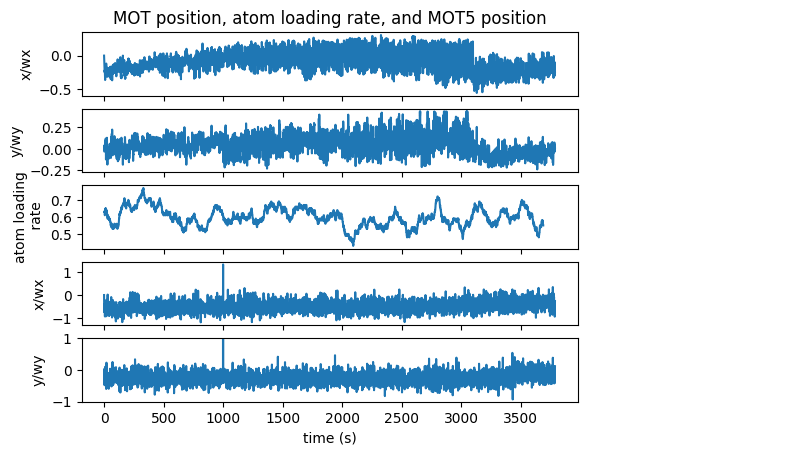

In [255]:
wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot((xmeans- xmeans[0])/wx,label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot((ymeans- ymeans[0])/wy,label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot((mot5xmeans - mot5xmeans[0]),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
# ax4.set_ylim((-0.05,0.05))
ax5.plot((mot5ymeans - mot5ymeans[0]),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-1,1))
ax5.set_xlabel("time (s)")
fig.legend(loc=(1.01,0.5))

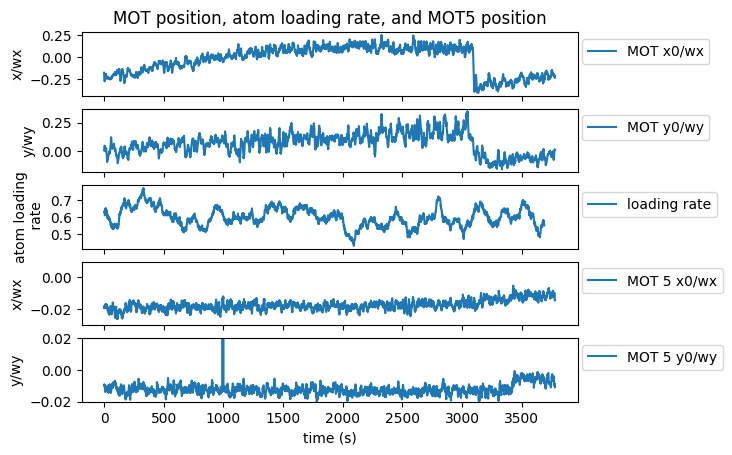

In [250]:
kernel = np.ones(10)/10
roll_avg = lambda data: np.convolve(data, kernel, 'valid')

wx = np.mean(xwidths)
wy = np.mean(ywidths)
fig,axes = plt.subplots(nrows=5,sharex=True)
ax,ax2,ax3,ax4,ax5 = axes
ax.plot(roll_avg((xmeans- xmeans[0])/wx),label='MOT x0/wx')
ax.set_ylabel("x/wx")
ax2.plot(roll_avg((ymeans- ymeans[0])/wy),label='MOT y0/wy')
ax2.set_ylabel("y/wy")
ax.set_title("MOT position, atom loading rate, and MOT5 position")
atom = [1 if x > 180 else 0 for x in counts]
ax3.plot(np.convolve(atom,np.ones(100)/100,'valid'),label='loading rate')
ax3.set_ylabel("atom loading\n rate")

mot5wx = np.mean(mot5xwidths)
mot5wy = np.mean(mot5ywidths)

ax4.plot(roll_avg((mot5xmeans - mot5xmeans[0])/mot5wx),label='MOT 5 x0/wx')
ax4.set_ylabel("x/wx")
ax4.set_ylim((-0.03,0.01))
ax5.plot(roll_avg((mot5ymeans - mot5ymeans[0])/mot5wy),label='MOT 5 y0/wy')
ax5.set_ylabel("y/wy")
ax5.set_ylim((-0.02,0.02))
ax5.set_xlabel("time (s)")
for ax in axes:
    ax.legend(loc=(1.01,0.5))